In [1]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Marvin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Marvin\anaconda3\lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



# Import der Basisdaten

### HIER MÜSSEN WIR NOCH EINMAL FESTHALTEN WOHER UNSERE DATEN KOMMEN UND DAS SAUBER AUFLISTEN

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

### Preisdaten: SMARD
Großhandels Strompreis auf die kWh-heruntergerechnet als Beispiel für einen Strompreis von z.B. dem Anbieter Tibber, welcher den Großhandelspreis an den Kunden stündlich weitergibt

### Lastprofile Synthetisch: synPRO (Frauenhofer)
Getrennte profile für Warmwasser, Heizung und Strom jeweils für einen 2, 4 und 6 Personen Haushalt in einem EFH

In [2]:
# data imports

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# load electricity price data
df_price_data = pd.read_csv("data/Strompreise2019_2022.csv", sep=";", decimal=".", usecols=[2,3,4])


# load loadprofile data
# 2 Inhabitants EFH
el_2p = pd.read_csv('data/loads/2Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_2p = pd.read_csv('data/loads/2Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_2p = pd.read_csv('data/loads/2Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 4 Inhabitants EFH
el_4p = pd.read_csv('data/loads/4Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_4p = pd.read_csv('data/loads/4Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_4p = pd.read_csv('data/loads/4Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 6 Inhabitants EFH
el_6p = pd.read_csv('data/loads/6Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_6p = pd.read_csv('data/loads/6Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_6p = pd.read_csv('data/loads/6Pers/neighbourhood_htg.csv', comment='#', sep=';')

# fill dataframe
df_data = pd.DataFrame()
df_data['pv'] = pv_data['electricity']
df_data['temp'] = temp_data['TT_TU']
df_data['ww_load_2p'] = dhw_2p['total']
df_data['ww_load_4p'] = dhw_4p['total']
df_data['ww_load_6p'] = dhw_6p['total']
df_data['e_load_2p'] = el_2p['total']
df_data['e_load_4p'] = el_4p['total']
df_data['e_load_6p'] = el_6p['total']
df_data['h_load_2p'] = htg_2p['total_htg']
df_data['h_load_4p'] = htg_4p['total_htg']
df_data['h_load_6p'] = htg_6p['total_htg']

# season operation of hydrogen system (If PV-power is higher than 0.55 then use ely, fc just in winter months)
df_season = pd.DataFrame()
df_season['ely_pv_threshhold'] = df_data['pv'].apply(lambda x: 1 if x >= 0.55 else 0)
df_season['fc_pv_threshhold'] = 1 - df_season['ely_pv_threshhold']
#df_season['ely'] = [1 if 1416 <= x <= 7296 else 0 for x in range(8760)]
df_season['ely'] = [1 for x in range(8760)]
df_season['fc'] = [0 if 3624 <= x <= 6552 else 1 for x in range(8760)]



#df_data.plot(y=["h_load_2p", "ww_load_2p", "e_load_2p"])
#df_season.plot(y=["ely", "fc"])

In [3]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# assumptions
wp_el_p_nom = 12.5  # kW

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)
df_data["wp_power_consumption"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["el_power"]),2)
df_data['wp_power_cons_norm'] = df_data["wp_power_consumption"] / wp_el_p_nom

df_data

,pv,temp,ww_load_2p,ww_load_4p,ww_load_6p,e_load_2p,e_load_4p,e_load_6p,h_load_2p,h_load_4p,h_load_6p,wp_COP_interp,wp_power_consumption,wp_power_cons_norm
0,0.0,NaN,0.000000,0.0,1.518594,0.087042,0.108191,0.136886,1.287577,1.274003,1.295842,NaN,NaN,NaN
1,0.0,NaN,0.000000,0.0,0.000000,0.087303,0.086217,0.135976,1.799948,1.798675,1.809386,NaN,NaN,NaN
2,0.0,NaN,0.000000,0.0,0.000000,0.086005,0.085922,0.135816,2.128495,2.127315,2.138208,NaN,NaN,NaN
3,0.0,NaN,0.000000,0.0,0.000000,0.082747,0.109169,0.181411,2.381928,2.364143,2.376183,NaN,NaN,NaN
4,0.0,NaN,0.000000,0.0,0.000000,0.075984,0.108558,0.179553,2.553156,2.529228,2.542549,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,NaN,0.000000,0.0,0.000000,0.143545,0.545067,0.574078,1.614701,1.330839,1.452981,NaN,NaN,NaN
8756,0.0,NaN,0.000000,0.0,0.035994,0.142139,0.228792,1.003943,1.681241,1.550685,1.110155,NaN,NaN,NaN
8757,0.0,NaN,0.000000,0.0,0.000000,0.142010,0.291029,0.977002,1.713969,1.539984,1.098378,NaN,NaN,NaN
8758,0.0,NaN,2.712356,0.0,0.971850,0.141723,0.330328,0.473260,1.708129,1.495063,1.420826,NaN,NaN,NaN


In [4]:
# reform data for multi investment periods

# globals
multi_years = range(2020, 2040, 6)
observation_period = multi_years[-1] - multi_years[0]
max_lifetime = observation_period + 1
freq = 3

# Multi Year Datasets
# copy data
df_mdata = df_data
df_mseason = df_season

# reindex datasets
df_mdata.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')
df_mseason.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')

# rescale
df_mdata_3h = df_mdata.resample(rule='3H').mean()
df_mdata_4h = df_mdata.resample(rule='4H').mean()
df_mdata_5h = df_mdata.resample(rule='5H').mean()
df_mseason_3h = df_mseason.resample(rule='3H').mean()


# multi period dataframe
# df_mdata_1h_xy = pd.concat([df_mdata]*len(multi_years), ignore_index=True)
df_mdata_3h_xy = pd.concat([df_mdata_3h]*len(multi_years), ignore_index=True)
df_mseason_3h_xy = pd.concat([df_mseason_3h]*len(multi_years), ignore_index=True)


# Price Scenarios for Electricity Rate
price_high = df_price_data['2022']
price_midhigh_high = (df_price_data['2022'] + ((df_price_data['2022'] + df_price_data['2021'])/2)) / 2
price_midhigh = (df_price_data['2022'] + df_price_data['2021'])/2
price_mid_midhigh = (df_price_data['2021'] + ((df_price_data['2021'] + df_price_data['2022'])/2)) / 2
price_mid = df_price_data['2021']
price_mid_midlow = (df_price_data['2021'] + ((df_price_data['2021'] + df_price_data['2020'])/2)) / 2
price_midlow = (df_price_data['2020'] + df_price_data['2021'])/2
price_midlow_low = (df_price_data['2020'] + ((df_price_data['2021'] + df_price_data['2020'])/2)) / 2
price_low = df_price_data['2020']
price_profile_lst = [price_high, price_midhigh_high, price_midhigh, price_mid_midhigh, price_mid,
                     price_mid_midlow, price_midlow, price_midlow_low, price_low]
support_year_amount = len(multi_years)
# data basis
price_scenario_h_to_l = price_high
price_scenario_l_to_h = price_low
# concatenating from high to low and the other way around
for i in range(1, support_year_amount):
    price_scenario_h_to_l = pd.concat([price_scenario_h_to_l, price_profile_lst[i]], ignore_index=True)
    price_scenario_l_to_h = pd.concat([price_scenario_l_to_h, price_profile_lst[len(price_profile_lst)-(i+1)]], ignore_index=True)
# reindex datasets
price_scenario_h_to_l.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760*support_year_amount, freq='H')
price_scenario_l_to_h.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760*support_year_amount, freq='H')

# high price szenario (h_to_l): higher yearly average price -> lower average prices
price_scenario_h_to_l_3h_xy = price_scenario_h_to_l.resample(rule='3H').mean()
# high price szenario (l_to_h): lower yearly average price -> higher average prices
price_scenario_l_to_h_3h_xy = price_scenario_l_to_h.resample(rule='3H').mean()



#print(df_data['e_load_4p'].sum())
#print(df_mdata_3h['e_load_4p'].sum()*freq)
#print(df_mdata_4h['e_load_4p'].sum()*4)
#print(df_mdata_5h['e_load_4p'].sum()*5)

# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

Kapitalkosten: Gesamtsystem spezifisch auf Nennleistung + Angabe der Lifetime(Annahme aller Komponenten mit 20 Jahre)

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis oder die Gebäudedefinition werden in einfachen globalen Variablen gespeichert

In [5]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.071    # €/kWh
gas_price = 0.158

# building related variables
living_space = 157 #m²

# grid parameters

# plot parameters
plt.rcParams.update({'font.size': 12})

# data calculations 
# -> here <-------------------!


# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'p_max_pu_multi': df_mdata_3h_xy['pv'],
    'capital_cost': 1750, #€/kWp
    'marginal_cost': 0,
    'lifetime' : 20,
    'pv_co2': 0   #kg/kWh
}

# Picea Home System: https://www.homepowersolutions.de/produkt/
# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'p_max_pu': df_season['fc'],
    'p_max_pu_multi': df_mseason_3h_xy['fc'],
    'el_efficiency': 0.6,
    'th_efficiency': 0.3,
    'capital_cost': 21250/1.5,
    'marginal_cost': 0,
    'lifetime' : 10,
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'p_max_pu': df_season['ely'],
    'p_max_pu_multi': df_mseason_3h_xy['ely'],
    'el_efficiency': 0.7,
    'th_efficiency': 0.2,
    'capital_cost': 21250/2.3,
    'marginal_cost': 0,
    'lifetime' : 10,
}

# H2 gas storage
h2_storage_params = {
    'e_nom_max': 1500/fc_params['el_efficiency'], #kWh_el - picea, auf 1500 kWh_el erweiterbar MEHR ENERGIE SPEICHERBAR
    'e_nom_min': 300/fc_params['el_efficiency'],
    'e_nom': 300/fc_params['el_efficiency'],
    'capital_cost': 21250/(300/fc_params['el_efficiency']), # € picea system
    'marginal_cost': 0, # Kosten Wasser
    'standing_loss': 0.00001,
    'lifetime' : 10,
    'h2_co2': 0   #kg/kWh
}

# battery storage
battery_picea_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    'e_nom_min': 10,
    #'e_max_pu': 1.0,
    'capital_cost': 21250/20,
    'marginal_cost': 0,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5.7,
    'discharge_power': 5.7,
    'lifetime' : 10
}

# Standard battery: https://greencell.global/de/energie-speichern/4846-green-cell-gc-powernest-energiespeicher-lifepo4-akku-5-kwh-48-v.html#specification
battery_params = {
    'e_nom': 5,
    'e_nom_min': 2,
    'capital_cost': 2630/5,
    'marginal_cost': 0,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5,
    'discharge_power': 5,
    'lifetime' : 10
}


# heatpump -> wp: https://www.viessmann.de/de/wissen/technik-und-systeme/waermepumpe.html
wp_params = {
    'p_nom': 13.2,
    'efficiency': df_data['wp_COP_interp'],
    'efficiency_multi': df_mdata_3h_xy['wp_COP_interp'],
    'capital_cost': 20000/13.2,
    'marginal_cost': 0,
    'lifetime' : 20
}

# heat storage: https://www.viessmann.de/de/produkte/warmwasserbereiter/vitocell-140-e.html
heat_storage_params = {
    'e_nom': 15, #kWh
    'e_nom_min': 5,
    'volume': 300, #Litre
    'capital_cost': 1465/15,
    'marginal_cost': 0,
    'standing_loss': 0.0875,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
    'lifetime' : 20
}

# heating rod: https://www.g2-energy-systems.de/elektroheizelemente-heizkoerper/elektroheizelemente/gekapselte-keramikheizpatronen/gekapselte-keramikheizstaebe-mit-flansch-keramische-heizelemente.html
heating_rod_params = {
    'p_nom': 2.2, #kW
    'p_nom_picea': 4.5, #kW
    'efficiency': 1,
    'capital_cost': 210/2.2,
    'capital_cost_picea': 210/4.5,
    'marginal_cost': 0,
    'lifetime' : 20
}

# Gas Boiler: https://www.klimaworld.com/vaillant-brennwerttherme-ecotec-plus-vcw-25-32-cs-1-5-0010043902.html?utm_source=google&utm_medium=cpc&_attribution=GoogleAds&gclid=CjwKCAjw5_GmBhBIEiwA5QSMxLOYbOb4IxBXSJmPPku7bedGxHHWe1i2163OTuT7KkkfBs4bLBmYkBoCTWcQAvD_BwE
gas_boiler_params = {
    'p_nom': 25, #kW
    'efficiency': 1.09,
    'capital_cost': 5650/25,
    'marginal_cost': 0,
    'lifetime' : 20
}


#CO2 emissions
co2_params = {
    'co2_emissions_germany_electricity': 0.434, #kg/kWh (https://de.statista.com/statistik/daten/studie/38897/umfrage/co2-emissionsfaktor-fuer-den-strommix-in-deutschland-seit-1990/#:~:text=Im%20Jahr%202022%20wurde%20der,mit%20kleinen%20Ausnahmen%20kontinuierlich%20ab.)
    'co2_emissions_gas' : 0.202 #kg/kWh (https://www.verbraucherzentrale.de/wissen/energie/heizen-und-warmwasser/klimapaket-was-bedeutet-es-fuer-mieter-und-hausbesitzer-43806)
}


# Auswertungs- und Grafische Darstellungsfunktionen

In [6]:
def auswertungsfunktion(network, sensitivity_variable=0, co2_constraint=0):
    #Funktion der laufenden kosten
    if network == n_h2:
        
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
        
        #Funktion der laufende Kosten
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid).sum()
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = 0


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= 0
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable], columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)
    else:
       
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
       
        #Funktion der laufende Kosten 
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid + 
                                      network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
        
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= (network.generators_t.p.infeed).sum()
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)

    return df_result

In [7]:
def opt_series_summary(network, h2=False, h2_gas=False, ref_gas=False, ref=False, multi_invest=False):
    '''
    This Method sums up all optimized time series data for each component
    
    return: 
    df_res_series (Networks optimized Time Series Data)
    
    use: df = opt_series_summary(NETWORK_NAME, CHOICE_VARIABLE=True)
    '''
    if multi_invest == True:
        snapshots = pd.DatetimeIndex([])
        for year in multi_years:
            period = pd.date_range(
                start="{}-01-01 00:00".format(year),
                freq="{}H".format(str(freq)),
                periods=8760 / float(freq),
            )
            snapshots = snapshots.append(period)
            
        date_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
    else: 
        date_index = pd.date_range(start='2022-01-01 00:00', end='2022-12-31 23:00', freq='H')
        
    if h2 == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage + 
                                                          network.stores_t.e.h2_storage_1 + 
                                                          network.stores_t.e.h2_storage_2 + 
                                                          network.stores_t.e.h2_storage_3).to_numpy(), index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc +
                                                          network.links_t.p0.fc_1 + 
                                                          network.links_t.p0.fc_2 + 
                                                          network.links_t.p0.fc_3).to_numpy(), index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely +
                                                          network.links_t.p0.ely_1 + 
                                                          network.links_t.p0.ely_2 + 
                                                          network.links_t.p0.ely_3).to_numpy(), index=date_index, columns=['Electrolysis']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery +
                                                          network.stores_t.e.battery_1 +
                                                          network.stores_t.e.battery_2 +
                                                          network.stores_t.e.battery_3).to_numpy(), index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),],
                                       axis = 1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                           pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                           pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                           pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                           pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                           pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                           pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                           pd.DataFrame(data=(network.stores_t.e.h2_storage + 
                                                              network.stores_t.e.h2_storage_1 + 
                                                              network.stores_t.e.h2_storage_2).to_numpy(), index=date_index, columns=['H2 Storage']),
                                           pd.DataFrame(data=(network.links_t.p0.fc +
                                                              network.links_t.p0.fc_1 + 
                                                              network.links_t.p0.fc_2).to_numpy(), index=date_index, columns=['Fuel Cell']),
                                           pd.DataFrame(data=(network.links_t.p0.ely +
                                                              network.links_t.p0.ely_1 + 
                                                              network.links_t.p0.ely_2).to_numpy(), index=date_index, columns=['Electrolysis']),
                                           pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                           pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                           pd.DataFrame(data=(network.stores_t.e.battery +
                                                              network.stores_t.e.battery_1 +
                                                              network.stores_t.e.battery_2).to_numpy(), index=date_index, columns=['Battery']),
                                           pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),],
                                          axis = 1)
            except:
                try:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                               pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                               pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                               pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                               pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                               pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                               pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                               pd.DataFrame(data=(network.stores_t.e.h2_storage + 
                                                                  network.stores_t.e.h2_storage_1).to_numpy(), index=date_index, columns=['H2 Storage']),
                                               pd.DataFrame(data=(network.links_t.p0.fc +
                                                                  network.links_t.p0.fc_1).to_numpy(), index=date_index, columns=['Fuel Cell']),
                                               pd.DataFrame(data=(network.links_t.p0.ely +
                                                                  network.links_t.p0.ely_1).to_numpy(), index=date_index, columns=['Electrolysis']),
                                               pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                               pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                               pd.DataFrame(data=(network.stores_t.e.battery +
                                                                  network.stores_t.e.battery_1).to_numpy(), index=date_index, columns=['Battery']),
                                               pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),],
                                              axis = 1)
                except:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                               pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                               pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                               pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                               pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                               pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                               pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                               pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), index=date_index, columns=['H2 Storage']),
                                               pd.DataFrame(data=network.links_t.p0.fc.to_numpy(), index=date_index, columns=['Fuel Cell']),
                                               pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), index=date_index, columns=['Electrolysis']),
                                               pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                               pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                               pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                               pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),],
                                              axis = 1)
                    
    elif h2_gas == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(), index=date_index, columns=['Gas Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(), index=date_index, columns=['Heating Rod']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']), 
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(), index=date_index, columns=['Boiler']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),
                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), index=date_index, columns=['H2 Storage']),
                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(), index=date_index, columns=['Fuel Cell']),
                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), index=date_index, columns=['Electrolysis'])],
                                   axis = 1)
    
    elif ref_gas == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(), index=date_index, columns=['Gas Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(), index=date_index, columns=['Heating Rod']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(), index=date_index, columns=['Boiler']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage'])],
                                   axis = 1)
    
    elif ref == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage'])],
                                   axis = 1)
    
    else:
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
            
    
    return df_res_series

In [8]:
def opt_value_summary(n1=None, n2=None, n3=None, n4=None, n12=False, n34=False, n_all=False):
    '''
    This Method sums up all optimized values for power and capacity
    n1 = Referenznetzwerk Gas
    n2 = H2-Netzwerk Gas
    n3 = Referenznetzwerk EE
    n4 = H2-Netzwerk EE
    
    return: 
    df_opt_values (Networks optimized values for comparation of GAS or EE respectively)
    
    use: df = opt_value_summary(NETWORK_NAME1, NETWORK_NAME2, ..., ... , CHOICE_VARIABLE=True)
    '''
    if n12 == True: # compare Gas Networks
        df1 = pd.concat([pd.DataFrame(data=n1.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.generators.p_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n1.stores.e_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.links.p_nom_opt.index, columns=["Ref Gas"])], axis=0)
        df2 = pd.concat([pd.DataFrame(data=n2.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.generators.p_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n2.stores.e_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.links.p_nom_opt.index, columns=["H2 Gas"])], axis=0)
        df_opt_values = pd.concat([df1, df2], axis=1, join='outer')
        
    elif n34 == True: # compare EE Networks
        df3 = pd.concat([pd.DataFrame(data=n3.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.generators.p_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n3.stores.e_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.links.p_nom_opt.index, columns=["Ref EE"])], axis=0)
        df4 = pd.concat([pd.DataFrame(data=n4.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.generators.p_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n4.stores.e_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.links.p_nom_opt.index, columns=["H2 EE"])], axis=0)
        df_opt_values = pd.concat([df3, df4], axis=1, join='outer')
        
    elif n_all == True: # compare all Networks
        df1 = pd.concat([pd.DataFrame(data=n1.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.generators.p_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n1.stores.e_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.links.p_nom_opt.index, columns=["Ref Gas"])], axis=0)
        df2 = pd.concat([pd.DataFrame(data=n2.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.generators.p_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n2.stores.e_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.links.p_nom_opt.index, columns=["H2 Gas"])], axis=0)
        df3 = pd.concat([pd.DataFrame(data=n3.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.generators.p_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n3.stores.e_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.links.p_nom_opt.index, columns=["Ref EE"])], axis=0)
        df4 = pd.concat([pd.DataFrame(data=n4.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.generators.p_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n4.stores.e_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.links.p_nom_opt.index, columns=["H2 EE"])], axis=0)
        df_opt_values = pd.concat([df1, df2, df3, df4], axis=1, join='outer')
        
    else:
        print("zutreffende Netzwerk-Kombination(n12, n34, n_all) für die Datenzusammenstellung auf (=True) setzen")
    
    return df_opt_values

In [9]:
def calc_global_results(n1=None, n2=None, n3=None, n4=None, n12=False, n34=False, n_all=False):
    '''
    This Method calculates results of each network and additionally combined results
    n1 = Referenznetzwerk Gas
    n2 = H2-Netzwerk Gas
    n3 = Referenznetzwerk EE
    n4 = H2-Netzwerk EE
    '''
    df_global_results = pd.DataFrame()
    
    # calculate result information
    if n12 == True: # compare Gas Networks
        # grid supply
        grid_supply1 = n1.generators_t.p.grid.sum() + n1.generators_t.p.gas.sum()
        grid_supply2 = n2.generators_t.p.grid.sum() + n2.generators_t.p.gas.sum()
        # grid ratios
        el_ratio1 = np.round((n1.generators_t.p.grid.sum()/grid_supply1)*100, 2)
        gas_ratio1 = np.round((n1.generators_t.p.gas.sum()/grid_supply1)*100, 2) 
        el_ratio2 = np.round((n2.generators_t.p.grid.sum()/grid_supply2)*100, 2) 
        gas_ratio2 = np.round((n2.generators_t.p.gas.sum()/grid_supply2)*100, 2) 
        # loads
        load1 = n1.loads_t.p.electric_load.sum() + n1.loads_t.p.heat_load.sum() + n1.loads_t.p.ww_load.sum()
        load2 = n2.loads_t.p.electric_load.sum() + n2.loads_t.p.heat_load.sum() + n2.loads_t.p.ww_load.sum()
        # self sufficiency
        aut1 = np.round(((load1 - grid_supply1) / load1)*100, 2)
        aut2 = np.round(((load2 - grid_supply2) / load2)*100, 2)
        # co2 emissions
        co2_1 = (n1.generators_t.p.sum() / n1.generators.efficiency *
                 pd.merge(n1.carriers, n1.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_2 = (n2.generators_t.p.sum() / n2.generators.efficiency *
                 pd.merge(n2.carriers, n2.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n1
        capex_stores1 = (n1.stores.e_nom_opt * n1.stores.capital_cost).sum()
        capex_gen1 = (n1.generators.p_nom_opt * n1.generators.capital_cost).sum()
        capex_links1 = (n1.links.p_nom_opt * n1.links.capital_cost).sum()
        capex1 = capex_stores1 + capex_gen1 + capex_links1
        # n2
        capex_stores2 = (n2.stores.e_nom_opt * n2.stores.capital_cost).sum()
        capex_gen2 = (n2.generators.p_nom_opt * n2.generators.capital_cost).sum()
        capex_links2 = (n2.links.p_nom_opt * n2.links.capital_cost).sum()
        capex2 = capex_stores2 + capex_gen2 + capex_links2
        
        # marginal cost system
        # n1
        try:
            opex1 = ((n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        except:
            opex1 = ((n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        # n2
        try:
            opex2 = ((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        except:
            opex2 = ((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf1 = (n1.generators_t.p.infeed * n1.generators.marginal_cost.infeed).sum()
        rev_inf2 = (n2.generators_t.p.infeed * n2.generators.marginal_cost.infeed).sum()
        # revenues from energy savings network intern
        rev_save1i = ((n1.generators_t.p.pv.sum() - n1.generators_t.p.infeed.sum()) 
                      * -((el_ratio1 * electricity_rate)+(gas_ratio1 * gas_price))
                     )
        rev_save2i = ((n2.generators_t.p.pv.sum() - n2.generators_t.p.infeed.sum()) 
                      * -((el_ratio2 * electricity_rate)+(gas_ratio2 * gas_price))
                     )
        
        # revenues from energy savings compared to reference network
        rev_save1 = 0
        try:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        except:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        if rev_save2 >= 0:
            rev_save2 = 0

            
        # payback period compared (Amortisation)
        payback1 = capex1 / -(rev_inf1 + rev_save1)
        payback2 = capex2 / -(rev_inf2 + rev_save2)
        
        # payback period intern
        payback1i = capex1 / -(rev_inf1 + rev_save1i)
        payback2i = capex2 / -(rev_inf2 + rev_save2i)
        
        df_global_results['Network'] = ['Ref_Gas', 'H2_Gas']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply1, grid_supply2], 0)
        df_global_results['Supply Ratio Gas [%]'] = [gas_ratio1, gas_ratio2]
        df_global_results['Supply Ratio Electric [%]'] = [el_ratio1, el_ratio2]
        df_global_results['Total Load [kWh/a]'] = np.round([load1, load2], 0)
        df_global_results['Self Sufficiency [%]'] = [aut1, aut2]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_1, co2_2], 0)
        df_global_results['CAPEX [€]'] = np.round([capex1, capex2], 2)
        df_global_results['OPEX [€]'] = np.round([opex1, opex2], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf1, rev_inf2], 2)
        df_global_results['Revenues Savings intern [€/a]'] = np.round([rev_save1i, rev_save2i], 2)
        df_global_results['Revenues Savings compared [€/a]'] = np.round([rev_save1, rev_save2], 2)
        df_global_results['Payback Period intern [a]'] = np.round([payback1i, payback2i], 0)
        df_global_results['Payback Period compared [a]'] = np.round([payback1, payback2], 0)
        
    elif n34 == True: # compare EE Networks
        # grid supply
        grid_supply3 = n3.generators_t.p.grid.sum()
        grid_supply4 = n4.generators_t.p.grid.sum()
        #grid ratios
        el_ratio3 = 100
        gas_ratio3 = 100 - el_ratio3
        el_ratio4 = 100
        gas_ratio4 = 100 - el_ratio4
        # loads
        load3 = n3.loads_t.p.electric_load.sum() + n3.loads_t.p.heat_load.sum() + n3.loads_t.p.ww_load.sum()
        load4 = n4.loads_t.p.electric_load.sum() + n4.loads_t.p.heat_load.sum() + n4.loads_t.p.ww_load.sum()
        # autarchy
        aut3 = np.round(((load3 - grid_supply3) / load3)*100, 2)
        aut4 = np.round(((load4 - grid_supply4) / load4)*100, 2)
        # co2 emissions
        co2_3 = (n3.generators_t.p.sum() / n3.generators.efficiency *
                 pd.merge(n3.carriers, n3.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_4 = (n4.generators_t.p.sum() / n4.generators.efficiency *
                 pd.merge(n4.carriers, n4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n3
        capex_stores3 = (n3.stores.e_nom_opt * n3.stores.capital_cost).sum()
        capex_gen3 = (n3.generators.p_nom_opt * n3.generators.capital_cost).sum()
        capex_links3 = (n3.links.p_nom_opt * n3.links.capital_cost).sum()
        capex3 = capex_stores3 + capex_gen3 + capex_links3
        # n4
        capex_stores4 = (n4.stores.e_nom_opt * n4.stores.capital_cost).sum()
        capex_gen4 = (n4.generators.p_nom_opt * n4.generators.capital_cost).sum()
        capex_links4 = (n4.links.p_nom_opt * n4.links.capital_cost).sum()
        capex4 = capex_stores4 + capex_gen4 + capex_links4
        
        # marginal cost system
        # n3
        try:
            opex3 = ((n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        except:
            opex3 = ((n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        # n4
        try:
            opex4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
        except:
            opex4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf3 = (n3.generators_t.p.infeed * n3.generators.marginal_cost.infeed).sum()
        rev_inf4 = (n4.generators_t.p.infeed * n4.generators.marginal_cost.infeed).sum()
        
        # revenues from energy savings network intern
        rev_save3i = (n3.generators_t.p.pv.sum() - n3.generators_t.p.infeed.sum()) * -(electricity_rate)
        rev_save4i = (n4.generators_t.p.pv.sum() - n4.generators_t.p.infeed.sum()) * -(electricity_rate)
        
        # revenues from energy savings compared to reference network
        rev_save3 = 0           
        try:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        except:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        if rev_save4 >= 0:
            rev_save4 = 0
            
        # payback period compared (Amortisation)
        payback3 = capex3 / -(rev_inf3 + rev_save3)
        payback4 = capex4 / -(rev_inf4 + rev_save4)
        
        # payback period intern
        payback3i = capex3 / -(rev_inf3 + rev_save3i)
        payback4i = capex4 / -(rev_inf4 + rev_save4i)
        
        df_global_results['Network'] = ['Ref_EE', 'H2_EE']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply3, grid_supply4], 0)
        df_global_results['Supply Ratio Gas [%]'] = [gas_ratio3, gas_ratio4]
        df_global_results['Supply Ratio Electric [%]'] = [el_ratio3, el_ratio4]
        df_global_results['Total Load [kWh/a]'] = np.round([load3, load4], 0)
        df_global_results['Self Sufficiency [%]'] = [aut3, aut4]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_3, co2_4], 0)
        df_global_results['CAPEX [€]'] = np.round([capex3, capex4], 2)
        df_global_results['OPEX [€]'] = np.round([opex3, opex4], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf3, rev_inf4], 2)
        df_global_results['Revenues Savings intern [€/a]'] = np.round([rev_save3i, rev_save4i], 2) #HIER IST DEFINITIV NOCH EIN FEHLER!!!!!!!!!!!
        df_global_results['Revenues Savings compared[€/a]'] = np.round([rev_save3, rev_save4], 2)
        df_global_results['Payback Period intern [a]'] = np.round([payback3i, payback4i], 0)
        df_global_results['Payback Period compared [a]'] = np.round([payback3, payback4], 0)
        
    elif n_all == True: # compare All Networks
        # grid supply
        grid_supply1 = n1.generators_t.p.grid.sum() + n1.generators_t.p.gas.sum()
        grid_supply2 = n2.generators_t.p.grid.sum() + n2.generators_t.p.gas.sum()
        grid_supply3 = n3.generators_t.p.grid.sum()
        grid_supply4 = n4.generators_t.p.grid.sum()
        # grid ratios
        el_ratio1 = np.round((n1.generators_t.p.grid.sum()/grid_supply1)*100, 2)
        gas_ratio1 = np.round((n1.generators_t.p.gas.sum()/grid_supply1)*100, 2) 
        el_ratio2 = np.round((n2.generators_t.p.grid.sum()/grid_supply2)*100, 2) 
        gas_ratio2 = np.round((n2.generators_t.p.gas.sum()/grid_supply2)*100, 2) 
        el_ratio3 = 100
        gas_ratio3 = 100 - el_ratio3
        el_ratio4 = 100
        gas_ratio4 = 100 - el_ratio4
        
        # loads
        load1 = n1.loads_t.p.electric_load.sum() + n1.loads_t.p.heat_load.sum() + n1.loads_t.p.ww_load.sum()
        load2 = n2.loads_t.p.electric_load.sum() + n2.loads_t.p.heat_load.sum() + n2.loads_t.p.ww_load.sum()
        load3 = n3.loads_t.p.electric_load.sum() + n3.loads_t.p.heat_load.sum() + n3.loads_t.p.ww_load.sum()
        load4 = n4.loads_t.p.electric_load.sum() + n4.loads_t.p.heat_load.sum() + n4.loads_t.p.ww_load.sum()
        # autarchy
        aut1 = np.round(((load1 - grid_supply1) / load1)*100, 2)
        aut2 = np.round(((load2 - grid_supply2) / load2)*100, 2)
        aut3 = np.round(((load3 - grid_supply3) / load3)*100, 2)
        aut4 = np.round(((load4 - grid_supply4) / load4)*100, 2)
        # co2 emissions
        co2_1 = (n1.generators_t.p.sum() / n1.generators.efficiency *
                 pd.merge(n1.carriers, n1.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_2 = (n2.generators_t.p.sum() / n2.generators.efficiency *
                 pd.merge(n2.carriers, n2.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_3 = (n3.generators_t.p.sum() / n3.generators.efficiency *
                 pd.merge(n3.carriers, n3.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_4 = (n4.generators_t.p.sum() / n4.generators.efficiency *
                 pd.merge(n4.carriers, n4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n1
        capex_stores1 = (n1.stores.e_nom_opt * n1.stores.capital_cost).sum()
        capex_gen1 = (n1.generators.p_nom_opt * n1.generators.capital_cost).sum()
        capex_links1 = (n1.links.p_nom_opt * n1.links.capital_cost).sum()
        capex1 = capex_stores1 + capex_gen1 + capex_links1
        # n2
        capex_stores2 = (n2.stores.e_nom_opt * n2.stores.capital_cost).sum()
        capex_gen2 = (n2.generators.p_nom_opt * n2.generators.capital_cost).sum()
        capex_links2 = (n2.links.p_nom_opt * n2.links.capital_cost).sum()
        capex2 = capex_stores2 + capex_gen2 + capex_links2
        # n3
        capex_stores3 = (n3.stores.e_nom_opt * n3.stores.capital_cost).sum()
        capex_gen3 = (n3.generators.p_nom_opt * n3.generators.capital_cost).sum()
        capex_links3 = (n3.links.p_nom_opt * n3.links.capital_cost).sum()
        capex3 = capex_stores3 + capex_gen3 + capex_links3
        # n4
        capex_stores4 = (n4.stores.e_nom_opt * n4.stores.capital_cost).sum()
        capex_gen4 = (n4.generators.p_nom_opt * n4.generators.capital_cost).sum()
        capex_links4 = (n4.links.p_nom_opt * n4.links.capital_cost).sum()
        capex4 = capex_stores4 + capex_gen4 + capex_links4
        
        # marginal cost system
        # n1
        try:
            opex1 = ((n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        except:
            opex1 = ((n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        # n2
        try:
            opex2 = ((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        except:
            opex2 = ((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        # n3
        try:
            opex3 = ((n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        except:
            opex3 = ((n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        # n4
        try:
            opex4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
        except:
            opex4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf1 = (n1.generators_t.p.infeed * n1.generators.marginal_cost.infeed).sum()
        rev_inf2 = (n2.generators_t.p.infeed * n2.generators.marginal_cost.infeed).sum()
        rev_inf3 = (n3.generators_t.p.infeed * n3.generators.marginal_cost.infeed).sum()
        rev_inf4 = (n4.generators_t.p.infeed * n4.generators.marginal_cost.infeed).sum()
        
        # revenues from energy savings network intern
        rev_save1i = ((n1.generators_t.p.pv.sum() - n1.generators_t.p.infeed.sum()) 
                      * -((el_ratio1 * electricity_rate)+(gas_ratio1 * gas_price))
                     )
        rev_save2i = ((n2.generators_t.p.pv.sum() - n2.generators_t.p.infeed.sum()) 
                      * -((el_ratio2 * electricity_rate)+(gas_ratio2 * gas_price))
                     )
        rev_save3i = (n3.generators_t.p.pv.sum() - n3.generators_t.p.infeed.sum()) * -(electricity_rate)
        rev_save4i = (n4.generators_t.p.pv.sum() - n4.generators_t.p.infeed.sum()) * -(electricity_rate)
        
        # revenues from energy savings compared to reference network
        rev_save1 = 0
        try:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        except:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        rev_save3 = 0
                     
        try:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        except:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        if rev_save2 >= 0:
            rev_save2 = 0
        if rev_save4 >= 0:
            rev_save4 = 0
            
        # payback period compared (Amortisation)
        payback1 = capex1 / -(rev_inf1 + rev_save1)
        payback2 = capex2 / -(rev_inf2 + rev_save2)
        payback3 = capex3 / -(rev_inf3 + rev_save3)
        payback4 = capex4 / -(rev_inf4 + rev_save4)
        
        # payback period intern
        payback1i = capex1 / -(rev_inf1 + rev_save1i)
        payback2i = capex2 / -(rev_inf2 + rev_save2i)
        payback3i = capex3 / -(rev_inf3 + rev_save3i)
        payback4i = capex4 / -(rev_inf4 + rev_save4i)
        
        df_global_results['Network'] = ['Ref_Gas', 'H2_Gas', 'Ref_EE', 'H2_EE']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply1, grid_supply2, grid_supply3, grid_supply4], 0)
        df_global_results['Supply Ratio Gas [%]'] = [gas_ratio1, gas_ratio2, gas_ratio3, gas_ratio4]
        df_global_results['Supply Ratio Electric [%]'] = [el_ratio1, el_ratio2, el_ratio3, el_ratio4]
        df_global_results['Total Load [kWh/a]'] = np.round([load1, load2, load3, load4], 0)
        df_global_results['Self Sufficiency [%]'] = [aut1, aut2, aut3, aut4]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_1, co2_2, co2_3, co2_4], 0)
        df_global_results['CAPEX [€]'] = np.round([capex1, capex2, capex3, capex4], 2)
        df_global_results['OPEX [€]'] = np.round([opex1, opex2, opex3, opex4], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf1, rev_inf2, rev_inf3, rev_inf4], 2)
        df_global_results['Revenues Savings intern [€/a]'] = np.round([rev_save1i, rev_save2i, rev_save3i, rev_save4i], 2)
        df_global_results['Revenues Savings compared [€/a]'] = np.round([rev_save1, rev_save2, rev_save3, rev_save4], 2)
        df_global_results['Payback Period intern [a]'] = np.round([payback1i, payback2i, payback3i, payback4i], 0)
        df_global_results['Payback Period compared [a]'] = np.round([payback1, payback2, payback3, payback4], 0)
        
    else:
        print("zutreffende Netzwerk-Kombination(n12, n34, n_all) für die Datenzusammenstellung auf (=True) setzen")
        
    return df_global_results

In [10]:
def plot_series_data(df_series_t, multi_invest=False):
    """
    This function generates plots to visualize time series data from the provided
    DataFrame `df_series_t`. Each column in the DataFrame represents a different
    time series alle time series are plotted in an overview in 5:4 or 4:4 Matrix.

    Parameters:
        df_series_t (DataFrame): The DataFrame containing time series data of each networks components.
        multiinvest (bool, optional): A Flag with the decicion on the x_axes format and the time period 
        of the plot summary. Default is False.

    Returns:
        None
    """
    # generate color cycle
    colors = plt.rcParams["axes.prop_cycle"]()
    
    # if more than 16 datasets -> add new row in plot
    if df_series_t.shape[1] > 16:
        rows = 5
    else:
        rows = 4
        
    # plot data
    fig, axes = plt.subplots(rows, 4, figsize=(16, 10))
    for col, ax in zip(df_series_t.columns, axes.flatten()):
        c = next(colors)["color"]
        if multi_invest == True:
            ax.plot(df_series_t.reset_index().index, df_series_t[col], color=c)
            ax.set_xticks(np.linspace(0, df_series_t.shape[0], len(multi_years)), labels=multi_years)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
        else:
            ax.plot(df_series_t.index, df_series_t[col], color=c)
            ax.set_xticks([])
            ax.set_xlabel("hours per year")
        ax.set_title(col)
        
        plt.subplots_adjust(wspace=.3, hspace=.45) 

In [11]:
def plot_opt_data(df_opt):
    """
    Plot overview of network optimization values for power and capacity.
    This function generates a plot to visualize the optimization values for power
    and capacity from the provided DataFrame.

    Parameters:
        df_opt (DataFrame): The DataFrame contains all optimized values (p_nom_opt;e_nom_opt).

    Returns:
        None
    """
    def get_cmap(n, name='hsv'):
        '''random color generator - SPEKTRUM'''
        return plt.cm.get_cmap(name, n)
    
    # if more than 2 dataset columns -> add new row in plot, if only 1 dataset just 1 plot
    if df_opt.shape[1] == 2:
        rows = 1
        cols = 2
        size_w = 14
        size_h = 8
    elif df_opt.shape[1] == 1:
        rows = 1
        cols = 1
        size_w = 14
        size_h = 6
    else:
        rows = 2
        cols = 2
        size_w = 14
        size_h = 8
    
    # reform the h2_storage value by /100 and rename the indicator
    if 'h2_storage' in df_opt.index:
        df_opt.loc['h2_storage'] = df_opt.loc['h2_storage'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage': 'h2_store*100'})
    if 'h2_storage_1' in df_opt.index:
        df_opt.loc['h2_storage_1'] = df_opt.loc['h2_storage_1'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_1': 'h2_store_1*100'})
    if 'h2_storage_2' in df_opt.index:
        df_opt.loc['h2_storage_2'] = df_opt.loc['h2_storage_2'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_2': 'h2_store_2*100'})
    if 'h2_storage_3' in df_opt.index:
        df_opt.loc['h2_storage_3'] = df_opt.loc['h2_storage_3'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_3': 'h2_store_3*100'})
    
    # generate colors
    N = 40
    cmap = get_cmap(N)
    
    # plot data
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(size_w, size_h), squeeze=False)
    for col, ax in zip(df_opt.columns, axes.flatten()):
        colors = [cmap(i) for i in range(0, 40, 2)]
        ax.bar(df_opt.index, df_opt[col], color=colors)
        ax.set_title(col)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylim(ymin=0, ymax=30)
        plt.subplots_adjust(wspace=.2, hspace=.7)

In [12]:
def analyse_single_network(n, h2=False, h2_gas=False, ref_gas=False, ref=False, sensitivity_variable=None,
                           plots=False, multi_invest=False):
    '''METHODS DOCSTRING
        This Methods gives a summary for a network passed as argument->(n)
        By setting the choice variable it generates datasets explicit for the given network
        Data shown by the function:
            1. Summarized energies and percentages for Grid(Electric/Gas) and Self Sufficiency Rate
            2. All p_nom_opt and e_nom_opt Values of the network
            3. Additional Plot Grafik for optimized values
            4. Time Series overview of all components as Plot Matrix
            5. Sensitivity evaluation when sensitivity variable != 0

        return: 
        If sensitivity variable = 0 return datasets -> print results and plots directly with argument ->(plots=True)
        df1) series_data (summary of time series data)
        df2) df_n_opt (Networks optimized values)    
        df3) analysis data (Sums of components and percentages like Self Sufficiency)
            use: df1, df2, df3 = analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True)
        otherwise:
        df1) df_sensitivity_results (Sensitivity DataFrame as output)
            use: df1 = df1.append(analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True, sensitivity_variable))
    '''
    
    # calculate multi_factor for calculation of analysis values according to whole observation period
    if multi_invest == True:
        observation_period = multi_years[-1] - multi_years[0]
        support_years = len(multi_years)
        multi_factor = freq / (support_years/observation_period)
    else:
        multi_factor = 1
        
    # co2 and capex calculation (equal for all networks)
    co2_val = (n.generators_t.p.sum()*multi_factor / n.generators.efficiency *
               pd.merge(n.carriers, n.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
    capex = ((n.stores.e_nom_opt * n.stores.capital_cost).sum() +
                 (n.generators.p_nom_opt * n.generators.capital_cost).sum() +
                 (n.links.p_nom_opt * n.links.capital_cost).sum())

    # network choice
    if h2 == True:
        
        # decide about multiinvest flag; generate series data
        if multi_invest == True:
            series_data = opt_series_summary(n, h2=True, multi_invest=True)
        else:
            series_data = opt_series_summary(n, h2=True)
            
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=['H2 EE optimized'])], axis=0)
        # summary of analytic value sums
        # side calculation
        try:
            rev_save = ((n.generators_t.p.pv - n.generators_t.p.infeed) *
                        -n.generators_t.marginal_cost.grid).sum()*multi_factor
            opex = (n.generators_t.p.grid * multi_factor * n.generators_t.marginal_cost.grid).sum()
        except:
            opex = n.generators_t.p.grid.sum() * multi_factor * electricity_rate
            rev_save = (n.generators_t.p.pv.sum()*multi_factor - 
                        n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
            
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() +
                       (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum() +
                           (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() +
                               (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()

        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          n.generators_t.p.pv.sum()*multi_factor,
                                          n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          (((n.loads_t.p.sum().sum()*multi_factor) - (n.generators_t.p.grid.sum()*multi_factor)) / n.loads_t.p.sum().sum()*multi_factor)*100, 
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          (capex+opex)/-((n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed) + rev_save)]},
                                   index=['CO2-Emission [kg/(a)]',
                                          'PV generated', 
                                          'PV used',
                                          'Amount Infeed',
                                          'Grid electric',
                                          'Grid gas',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored', 
                                          'Heat Storage stored', 
                                          'H2 stored', 
                                          'converted to H2',
                                          'H2 used',
                                          'Heat from H2', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€]',
                                          'Revenue Infeed [€/(a)]',
                                          'Revenue Savings [€/(a)]',
                                          'Payback Period [a]']).round(decimals=2)

        
    elif h2_gas == True:
        
        # decide about multi_invest flag; generate series data
        if multi_invest == True:
            series_data = opt_series_summary(n, h2=True, multi_invest=True)
        else:
            series_data = opt_series_summary(n, h2=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2),
                                           index=n.generators.p_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["H2 Gas optimized"])], axis=0)
        # summary of analytic value sums
        # side calculations
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor +
                                                              n.generators_t.p.gas.sum())*multi_factor)
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor +
                                                              n.generators_t.p.gas.sum())*multi_factor)
        
        try:
            opex = ((n.generators_t.p.grid * multi_factor * n.generators_t.marginal_cost.grid).sum() + 
                    (n.generators_t.p.gas * multi_factor * gas_price).sum()
                   )
            rev_save = ((n.generators_t.p.pv.sum() - n.generators_t.p.infeed.sum()) * multi_factor *
                        -((el_ratio * n.generators_t.marginal_cost.grid.sum())+(gas_ratio * gas_price))
                       )
        except:
            opex = n.generators_t.p.grid.sum() * multi_factor * electricity_rate
            rev_save = ((n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) *
                        -((el_ratio * electricity_rate)+(gas_ratio * gas_price))
                       )
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() +
                       (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum() +
                           (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() +
                               (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()

                    
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          n.generators_t.p.pv.sum()*multi_factor,
                                          n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          (((n.loads_t.p.sum().sum()*multi_factor) - (n.generators_t.p.grid.sum()*multi_factor)) / n.loads_t.p.sum().sum()*multi_factor)*100, 
                                          capex, 
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          (capex+opex)/-((n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed) + rev_save)]},
                                   index=['CO2-Emission [kg/(a)]',
                                          'PV generated', 
                                          'PV used',
                                          'Amount Infeed',
                                          'Grid electric',
                                          'Grid gas',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored', 
                                          'Heat Storage stored', 
                                          'H2 stored', 
                                          'converted to H2', 
                                          'H2 used', 
                                          'Heat from H2', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€]',
                                          'Revenue Infeed [€/(a)]',
                                          'Revenue Savings [€/(a)]',
                                          'Payback Period [a]']).round(decimals=2)
        
        
    elif ref_gas == True:
        
        # generate series data
        if multi_invest == True:
            series_data = opt_series_summary(n, h2=True, multi_invest=True)
        else:
            series_data = opt_series_summary(n, h2=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref Gas optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor +
                                                              n.generators_t.p.gas.sum())*multi_factor)
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor +
                                                              n.generators_t.p.gas.sum())*multi_factor)
        try:
            opex = ((n.generators_t.p.grid * multi_factor * n.generators_t.marginal_cost.grid).sum() + 
                    (n.generators_t.p.gas * multi_factor * gas_price).sum()
                   )
            rev_save = ((n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) *
                    -((el_ratio * n.generators_t.marginal_cost.grid.sum())+(gas_ratio * gas_price))
                   )
        except:
            opex = n.generators_t.p.grid.sum() * multi_factor * electricity_rate
            rev_save = ((n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) *
                    -((el_ratio * electricity_rate)+(gas_ratio * gas_price))
                   )
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          n.generators_t.p.pv.sum()*multi_factor,
                                          n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0,
                                          ((n.loads_t.p.sum().sum()*multi_factor -
                                            (n.generators_t.p.grid.sum()*multi_factor +
                                             n.generators_t.p.gas.sum()*multi_factor))/n.loads_t.p.sum().sum()*multi_factor)*100,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          (capex+opex)/-((n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed) + rev_save)]},
                                   index=['CO2-Emission [kg/(a)]',
                                          'PV generated', 
                                          'PV used',
                                          'Amount Infeed',
                                          'Grid electric',
                                          'Grid gas',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored', 
                                          'Heat Storage stored', 
                                          'H2 stored', 
                                          'converted to H2',
                                          'H2 used',
                                          'Heat from H2',
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€]',
                                          'Revenue Infeed [€/(a)]',
                                          'Revenue Savings [€/(a)]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    elif ref == True:
        # generate series data
        if multi_invest == True:
            series_data = opt_series_summary(n, h2=True, multi_invest=True)
        else:
            series_data = opt_series_summary(n, h2=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref EE optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        try:
            rev_save = ((n.generators_t.p.pv - n.generators_t.p.infeed) *
                        -n.generators_t.marginal_cost.grid).sum()*multi_factor
            opex = (n.generators_t.p.grid * multi_factor * n.generators_t.marginal_cost.grid).sum()
        except:
            opex = n.generators_t.p.grid.sum() * multi_factor * electricity_rate
            rev_save = (n.generators_t.p.pv.sum()*multi_factor - 
                        n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
                    
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          n.generators_t.p.pv.sum()*multi_factor,
                                          n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0, 
                                          ((n.loads_t.p.sum().sum()*multi_factor -
                                            (n.generators_t.p.grid.sum()*multi_factor+0)) / n.loads_t.p.sum().sum()*multi_factor)*100,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          (capex+opex)/-((n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed) + rev_save)]},
                                   index=['CO2-Emission [kg/(a)]',
                                          'PV generated', 
                                          'PV used',
                                          'Amount Infeed',
                                          'Grid electric',
                                          'Grid gas',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored', 
                                          'Heat Storage stored', 
                                          'H2 stored', 
                                          'converted to H2',
                                          'H2 used',
                                          'Heat from H2', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€]',
                                          'Revenue Infeed [€/(a)]',
                                          'Revenue Savings [€/(a)]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    else:
        # if no choice variable set -> 
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
    
    
    # decide for return values and output
    if sensitivity_variable != None:
        # generate sensitivity results
        df_sensitivity_results = pd.concat([pd.DataFrame(data=df_analysis.loc['CO2-Emission [kg/a]', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['CO2-Emission [kg/a]']),
                                            pd.DataFrame(data=df_analysis.loc['PV generated', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['PV generated']),
                                            pd.DataFrame(data=df_analysis.loc['PV used', 'analytic values'], index=[sensitivity_variable], 
                                                         columns=['PV used']),
                                            pd.DataFrame(data=df_analysis.loc['Amount Infeed', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['Amount Infeed']),
                                            pd.DataFrame(data=df_analysis.loc['Grid electric', 'analytic values'], index=[sensitivity_variable], 
                                                         columns=['Grid electric']),
                                            pd.DataFrame(data=df_analysis.loc['Grid gas', 'analytic values'], index=[sensitivity_variable], 
                                                         columns=['Grid gas']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio electric [%]', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['Ratio electric [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio gas [%]', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['Ratio gas [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Battery stored', 'analytic values'], index=[sensitivity_variable], 
                                                         columns=['Battery stored']),
                                            pd.DataFrame(data=df_analysis.loc['Heat Storage stored', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['Heat Storage stored']),
                                            pd.DataFrame(data=df_analysis.loc['H2 stored', 'analytic values'], index=[sensitivity_variable], 
                                                         columns=['H2 stored']),
                                            pd.DataFrame(data=df_analysis.loc['converted to H2', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['converted to H2']),
                                            pd.DataFrame(data=df_analysis.loc['H2 used', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['H2 used']),
                                            pd.DataFrame(data=df_analysis.loc['Heat from H2', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['Heat from H2']),
                                            pd.DataFrame(data=df_analysis.loc['Self Sufficiency [%]', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['Self Sufficiency [%]']),
                                            pd.DataFrame(data=df_analysis.loc['CAPEX [€]', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['CAPEX [€]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Infeed [€/a]', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['Revenue Infeed [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Savings [€/a]', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['Revenue Savings [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Payback Period [a]', 'analytic values'], index=[sensitivity_variable],
                                                         columns=['Payback Period [a]']),],
                                           axis=1)
    
        return df_sensitivity_results
    else:
        if plots == True:
            print("\nNetwork analytics: \n", df_analysis, "\n\nOptimized p_nom and e_nom and equivalent plot: \n", df_n_opt)
            plot_opt_data(df_n_opt)
            if multi_invest == True:
                plot_series_data(series_data, multi_invest=True)
            else:
                plot_series_data(series_data)
            return (series_data, df_n_opt, df_analysis)
        else:
            return (series_data, df_n_opt, df_analysis)

In [13]:
def cost_reduction_calculation(initial_cost=1000):
    '''METHODS DOCSTRING
        Arguments:
        initial_cost = Component cost before price reduction
        
            
        Parameters:
        Ct1 is unit cost of given cumulative production at time t [€/kW]
        C0 is unit cost at t=0 [€/kW]
        Qt1 is cumulative production by firm at time t [kW;MW;GW]
        Q0 is cumulative production by firm at t=0 [kW;MW;GW]
        t0 is the current time or the point in time where Price and Quantity Data ist available [a]
        t1 is a future or a later point in time where Price and Quantity Data is available [a]
        b is rate of innovation or learning parameter (while the cost
            decreases with increase in production, value of b is negative) 
        learning_rate = 1 - progress_ratio:

        price dataset in 3 scenarios according to the given initial cost
        return: 
        df1) df_cost_reduction
            use: df = cost_reduction_calculation(initial_cost=VALUE)
        
    '''
    # Values Cost and Quantity (estimated by grafik): https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/cost-forecast-for-low-temperature-electrolysis.pdf
    # mean value after calculation 3-4 datasets für assumption of the learning_rate or cost_reduction assumption
    Qt_2020 = 4
    Qt_2030 = 6100
    prices_2020 = [980, 720, 380, 290] #€/kW
    prices_2030 = [740, 500, 330, 220] #€/kW

    df_costred = pd.DataFrame(data={'year': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
                                     'Qts' : [4, 9, 25, 35, 55, 105, 500, 750, 1800, 3500, 6100]})

    # calculation first from base year 2020
    # determine the learning_rate, value(b) and progress_ratio for 2020 - 2030
    # dtermine the Costs in between for all 4 price scenarios
    b = []
    learning_rate = []
    progress_ratio = []

    for i in range(4):
        b.append(np.log(prices_2030[i]/prices_2020[i])/np.log(Qt_2030/Qt_2020))
        progress_ratio.append(np.power(2, b[i]))
        learning_rate.append(1 - progress_ratio[i])

    params_dict = {'b' : b,
                  'PR': progress_ratio,
                  'LR': learning_rate}

    # cases from 2020 up -> Calculation of Ct    
    Ct_case1 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][0]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case2 = list(map(lambda x: prices_2020[1] * np.power((x / Qt_2020), params_dict['b'][1]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case3 = list(map(lambda x: prices_2020[2] * np.power((x / Qt_2020), params_dict['b'][2]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case4 = list(map(lambda x: prices_2020[3] * np.power((x / Qt_2020), params_dict['b'][3]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case1.append(prices_2030[0])
    Ct_case2.append(prices_2030[1])
    Ct_case3.append(prices_2030[2])
    Ct_case4.append(prices_2030[3])
    Ct_case1.insert(0, prices_2020[0])
    Ct_case2.insert(0, prices_2020[1])
    Ct_case3.insert(0, prices_2020[2])
    Ct_case4.insert(0, prices_2020[3])

    df_costred['Ct1'] = Ct_case1
    df_costred['Ct2'] = Ct_case2
    df_costred['Ct3'] = Ct_case3
    df_costred['Ct4'] = Ct_case4
    # additional value for 2050 forecast (Europe): https://www.ieg.fraunhofer.de/content/dam/ieg/documents/pressemitteilungen/2019-10_Fraunhofer_Wasserstoff-Roadmap_fuer_Deutschland.pdf
    neu1 = prices_2020[0] * np.power((50000 / Qt_2020), params_dict['b'][0])
    neu2 = prices_2020[1] * np.power((50000 / Qt_2020), params_dict['b'][1])
    neu3 = prices_2020[2] * np.power((50000 / Qt_2020), params_dict['b'][2])
    neu4 = prices_2020[3] * np.power((50000 / Qt_2020), params_dict['b'][3])
    df_costred = df_costred.append({'year': 2050, 'Qts': 50000, 'Ct1': neu1, 'Ct2': neu2, 'Ct3': neu3, 'Ct4': neu4}, ignore_index=True)

    # Learning rate shows a unexpected low percentage value of below 4%. typical Learning Rates are estimated by 10-20%
    # But in logarithmic scale the curve is rather correct compared to literature: https://www.researchgate.net/figure/Learning-curve-for-energy-technologies-IEA-2000_fig1_5216285
    # Adding a mean value of all model cases might be an option
    df_costred['mean_Ct'] = (df_costred['Ct1'] + df_costred['Ct2'] + df_costred['Ct3'] + df_costred['Ct4']) / 4 
    df_costred['red1'] = df_costred['Ct1'] / prices_2020[0]
    df_costred['red2'] = df_costred['Ct2'] / prices_2020[1]
    df_costred['red3'] = df_costred['Ct3'] / prices_2020[2]
    df_costred['red4'] = df_costred['Ct4'] / prices_2020[3]
    df_costred['red5_mean'] = df_costred['mean_Ct'] / df_costred.loc[0, 'mean_Ct']

    #linear interpolation between 2030 - 2050 Geradegleichung Über geogebra bestimmt
    def linear_cost(x, m=-2.484173, b=5542.871799):
        return m * x + b
    def linear_quant(x, m=2195, b=-4449750):
        return m * x + b
    
    x_vals = [i for i in range(2020, 2051, 1)]
    yq_vals = []
    y_vals = []
    for x in x_vals:
        y_vals.append(linear_cost(x))
        yq_vals.append(linear_quant(x))

    
    df_capex_reduction = pd.DataFrame()
    df_capex_reduction['year'] = x_vals
    df_capex_reduction['quantities'] = list(df_costred['Qts'][:11])+[x for x in yq_vals[-20:]]
    df_capex_reduction['capex_model1'] = list(df_costred['Ct1'][:11])+[x + 238 for x in y_vals[-20:]]
    df_capex_reduction['capex_model2'] = list(df_costred['Ct2'][:11])+list(y_vals[-20:])
    df_capex_reduction['capex_model3'] = list(df_costred['Ct3'][:11])+[x - 172 for x in y_vals[-20:]] 
    df_capex_reduction['reduced_percentage1'] = df_capex_reduction['capex_model1'] / df_capex_reduction['capex_model1'][0]
    df_capex_reduction['reduced_percentage2'] = df_capex_reduction['capex_model2'] / df_capex_reduction['capex_model2'][0]
    df_capex_reduction['reduced_percentage3'] = df_capex_reduction['capex_model3'] / df_capex_reduction['capex_model3'][0]

    #df_capex_reduction.plot(x='year', y=['capex_model1', 'capex_model2', 'capex_model3'], logx=True, logy=True, figsize=(18,8))
    #df_capex_reduction
    
    
    factor_max = 1
    factor_std = df_capex_reduction['capex_model2'][0] / df_capex_reduction['capex_model1'][0] 
    factor_min = df_capex_reduction['capex_model3'][0] / df_capex_reduction['capex_model1'][0] 
    
    df_cost_reduction = pd.DataFrame()
    df_cost_reduction['year'] = x_vals
    df_cost_reduction["max"] = initial_cost * factor_max * df_capex_reduction['reduced_percentage1']
    df_cost_reduction["std"] = initial_cost * factor_std * df_capex_reduction['reduced_percentage2']
    df_cost_reduction["min"] = initial_cost * factor_min * df_capex_reduction['reduced_percentage3']
    
    return df_cost_reduction

# Referenzmodelle

In [14]:
def build_ref_network_gas(electric_load=df_data['e_load_2p'], 
                          heat_load=df_data['h_load_2p'],
                          ww_load=df_data['ww_load_2p']):

    # initialyze network
    n_gas = pypsa.Network()
    n_gas.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_gas.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_gas.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_gas.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_gas.add('Bus', name='electricity')
    n_gas.add('Bus', name='bat_bus')    
    # heat buses
    n_gas.add('Bus', name='heat')
    n_gas.add('Bus', name='heat_storage_bus')
    # gas bus
    n_gas.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_gas.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_gas.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_gas.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_gas.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
              lifetime = pv_params['lifetime'],
              carrier='pv_electricity')
    # grid  
    n_gas.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_gas.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)
    # gas
    n_gas.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_gas.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              marginal_cost = battery_params['marginal_cost'],
              standing_loss = battery_params['standing_loss'], 
              #e_nom_min = battery_params['e_nom'],
              lifetime = battery_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_gas.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'], 
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              #e_nom_min = heat_storage_params['e_nom_min'],
              lifetime = heat_storage_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    
    n_gas.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_gas.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
              
    n_gas.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              marginal_cost = gas_boiler_params['marginal_cost'],
              lifetime = gas_boiler_params['lifetime'],
              p_nom_max = gas_boiler_params['p_nom'],
              carrier = 'gas',
              p_nom_extendable = True)
    
    n_gas.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost'],
              marginal_cost = heating_rod_params['marginal_cost'],
              lifetime = heating_rod_params['lifetime'], 
              #p_nom_max = heating_rod_params['p_nom'],
              p_nom_extendable = True)
    
    n_gas.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    n_gas.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    
    # Global Constraints
    n_gas.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_gas

In [15]:
def build_ref_network(electric_load=df_data['e_load_2p'],
                      heat_load=df_data['h_load_2p'],
                      ww_load=df_data['ww_load_2p']):

    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_ref.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_ref.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_ref.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
              lifetime = pv_params['lifetime'], 
              carrier='pv_electricity')
    # grid  
    n_ref.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'],
              marginal_cost = battery_params['marginal_cost'],  
              standing_loss = battery_params['standing_loss'],
              lifetime = battery_params['lifetime'],
              e_nom_min = battery_params['e_nom'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_ref.add('Store', name='heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              lifetime = heat_storage_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
    
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              marginal_cost = wp_params['marginal_cost'],
              lifetime = wp_params['lifetime'],
              p_nom_max = wp_params['p_nom'],
              p_nom_extendable = True,)
    
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom = wp_params["p_nom"])
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom = wp_params["p_nom"])
    
    # Global Constraints
    n_ref.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_ref

In [16]:
#n_ref_gas = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])

#n_ref_gas.optimize(solver_name='gurobi')

#rg_series, rg_opt, rg_any = analyse_single_network(n_ref_gas, ref_gas=True, plots=True)

In [17]:
#n_ref = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])

#n_ref.optimize(solver_name='gurobi')

#r_series, r_opt, r_any = analyse_single_network(n_ref, ref=True, plots=True)


# Wasserstoffmodelle

In [18]:
def build_h2_network_gas(electric_load=df_data['e_load_2p'],
                         heat_load=df_data['h_load_2p'],
                         ww_load=df_data['ww_load_2p']):
    
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2g = pypsa.Network(override_component_attrs=override_component_attrs)
    #n_h2 = pypsa.Network()
    n_h2g.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_h2g.add('Carrier', name = 'grid_electricity', 
             co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2g.add('Carrier', name = 'pv_electricity', 
             co2_emissions = pv_params['pv_co2'])
    n_h2g.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_h2g.add('Carrier', name = 'h2_electricity', 
             co2_emissions = h2_storage_params['h2_co2'])
    
    # Buses 
    # electrical buses
    n_h2g.add('Bus', name='electricity')
    n_h2g.add('Bus', name='bat_bus')    
    # heat buses
    n_h2g.add('Bus', name='heat')
    n_h2g.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2g.add('Bus', name='h2_bus', carrier='h2_electricity')
    n_h2g.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_h2g.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_h2g.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_h2g.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)
    
    # Generators
    n_h2g.add('Generator', name='pv', bus='electricity',
             p_set = pv_params['p_nom'] * pv_params['p_max_pu'],
             p_nom = pv_params['p_nom'],
             p_max_pu = pv_params['p_max_pu'],
             capital_cost = pv_params['capital_cost'],
             marginal_cost = pv_params['marginal_cost'],
             lifetime = pv_params['lifetime'],
             carrier='pv_electricity')
    # grid
    n_h2g.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_h2g.add('Generator', name='grid', bus='electricity', 
              marginal_cost = electricity_rate,
              p_nom_extendable = True,
              carrier = 'grid_electricity')
    # gas grid
    n_h2g.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_h2g.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_picea_params['capital_cost'],
              marginal_cost = battery_picea_params['marginal_cost'], 
              standing_loss = battery_picea_params['standing_loss'],
              lifetime = battery_picea_params['lifetime'],
              e_nom = battery_picea_params['e_nom'],
              e_cyclic = True)
    
    n_h2g.add('Store', name='heat_storage', bus='heat_storage_bus',
              #e_nom = heat_storage_params['e_nom'],
              capital_cost = heat_storage_params['capital_cost'],
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              lifetime = heat_storage_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_h2g.add('Store', name='h2_storage', bus='h2_bus',
              capital_cost = h2_storage_params['capital_cost'],
              marginal_cost = h2_storage_params['marginal_cost'],
              standing_loss = h2_storage_params['standing_loss'],
              e_nom_min = h2_storage_params['e_nom_min'],
              #e_nom_max = h2_storage_params['e_nom_max'],
              lifetime = h2_storage_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_h2g.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_picea_params['charge_power'],
              efficiency = battery_picea_params['charge_efficiency'])
    n_h2g.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_picea_params['discharge_power'],
              efficiency = battery_picea_params['discharge_efficiency'])
    
    n_h2g.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost_picea'],
              marginal_cost = heating_rod_params['marginal_cost'],
              lifetime = heating_rod_params['lifetime'],
              p_nom_max = heating_rod_params['p_nom_picea'],
              p_nom_extendable = True)
    
    n_h2g.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              marginal_cost = gas_boiler_params['marginal_cost'],
              lifetime = gas_boiler_params['lifetime'],
              carrier = 'gas',
              p_nom_max = gas_boiler_params['p_nom'],
              p_nom_extendable = True)
    
    n_h2g.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = gas_boiler_params['p_nom'])
    n_h2g.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = gas_boiler_params['p_nom'])

    
    # Multilinks
    # electrolysis
    n_h2g.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             marginal_cost = ely_params['marginal_cost'],
             p_nom = ely_params['p_nom'],
             p_max_pu = df_season['ely'],
             lifetime = ely_params['lifetime'],
             carrier='h2_electricity')
    # fuellcell
    n_h2g.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             marginal_cost = fc_params['marginal_cost'],
             p_nom = fc_params['p_nom'],
             p_max_pu = df_season['fc'],
             lifetime = fc_params['lifetime'],
             carrier='h2_electricity')
    
    
    '''
    # electrolysis
    n_h2g.add('Link', name='ely1', bus0='electricity', bus1='h2_bus',
             efficiency = ely_params['el_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    n_h2g.add('Link', name='ely2', bus0='electricity', bus1='heat',
             efficiency = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    # fuellcell
    n_h2g.add('Link', name='fc1', bus0='h2_bus', bus1='electricity',
             efficiency = fc_params['el_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    n_h2g.add('Link', name='fc2', bus0='h2_bus', bus1='heat',
             efficiency = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    '''
    
    # Global Constraints
    n_h2g.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
            carrier_attribute = 'co2_emissions', constant = np.inf)
    return n_h2g

In [24]:
def build_h2_network(electric_load=df_data['e_load_2p'], 
                     heat_load=df_data['h_load_2p'],
                     ww_load=df_data['ww_load_2p']):
    
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
    n_h2.set_snapshots(range(8760))

    # add components
    
    # Carrier
    
    n_h2.add('Carrier', name = 'grid_electricity', 
             co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2.add('Carrier', name = 'pv_electricity', 
             co2_emissions = pv_params['pv_co2'])
    n_h2.add('Carrier', name = 'h2_electricity', 
             co2_emissions = h2_storage_params['h2_co2'])
    # Buses 
    # electrical buses
    n_h2.add('Bus', name='electricity')
    n_h2.add('Bus', name='bat_bus')
    # heat buses
    n_h2.add('Bus', name='heat')
    n_h2.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2.add('Bus', name='h2_bus', carrier='h2_electricity')

    # Loads
    # electrical
    n_h2.add('Load', name='electric_load', bus='electricity',
             p_set = electric_load)
    # heat
    n_h2.add('Load', name='heat_load', bus='heat', 
             p_set = heat_load)
    # warm water
    n_h2.add('Load', name='ww_load', bus='heat_storage_bus', 
             p_set = ww_load)

    # Generators
    n_h2.add('Generator', name='pv', bus='electricity',
             p_nom = pv_params['p_nom'],
             p_max_pu = pv_params['p_max_pu'].to_numpy(),
             capital_cost = pv_params['capital_cost'],
             marginal_cost = pv_params['marginal_cost'],
             carrier='pv_electricity')
    # grid
    n_h2.add('Generator', name='infeed', bus='electricity',
             marginal_cost = infeed_rate,
             sign = -1, 
             p_nom_extendable = True)
    n_h2.add('Generator', name='grid', bus='electricity', 
             marginal_cost = electricity_rate,
             p_nom_extendable = True,
             carrier = 'grid_electricity')


    # Storages
    n_h2.add('Store', name='battery',  bus='bat_bus',
             capital_cost = battery_picea_params['capital_cost'],
             marginal_cost = battery_picea_params['marginal_cost'], 
             standing_loss = battery_picea_params['standing_loss'],
             e_nom = battery_picea_params['e_nom'],
             e_cyclic = True)
    n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
             #e_nom = heat_storage_params['e_nom'],
             capital_cost = heat_storage_params['capital_cost'],
             marginal_cost = heat_storage_params['marginal_cost'],
             standing_loss = heat_storage_params['standing_loss'],
             e_nom_extendable = True,
             e_cyclic = True)
    n_h2.add('Store', name='h2_storage', bus='h2_bus',
             capital_cost = h2_storage_params['capital_cost'],
             marginal_cost = h2_storage_params['marginal_cost'],
             standing_loss = h2_storage_params['standing_loss'],
             e_nom_min = h2_storage_params['e_nom_min'],
             #e_nom_max = h2_storage_params['e_nom_max'],
             e_nom_extendable = True,
             e_cyclic = True)


    # Links
    n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_picea_params['charge_power'],
              efficiency = battery_picea_params['charge_efficiency'])
    n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_picea_params['discharge_power'],
              efficiency = battery_picea_params['discharge_efficiency'])
    
    n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
             efficiency = wp_params['efficiency'],
             capital_cost = wp_params['capital_cost'],
             marginal_cost = wp_params['marginal_cost'],
             p_nom_extendable = True,
             p_nom_max = wp_params['p_nom'])
    
    n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])

    
    # Multilinks
    # electrolysis
    n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             marginal_cost = ely_params['marginal_cost'],
             p_nom = ely_params['p_nom'],
             p_max_pu = ely_params['p_max_pu'].to_numpy(),
             carrier='h2_electricity')
    # fuellcell
    n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             marginal_cost = fc_params['marginal_cost'],
             p_nom = fc_params['p_nom'],
             p_max_pu = fc_params['p_max_pu'].to_numpy(),
             carrier='h2_electricity')
        
    # Global Constraints
    n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
             carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_h2

In [25]:
def build_h2_network_m(electric_load, heat_load, ww_load, 
                       multi_invest=False, cost_scenario=None, 
                       init_build_year=multi_years[0]):
    
    
    print("Settings: \n","Multi-Invest ON?: ",multi_invest, 
          "\n Chosen cost reduction scenario: ", cost_scenario, 
          "\n Start year for H2-Components: ", init_build_year)
    
    def replace_component(lifetime_temp=50):
        '''This function gives the replacement years for a component based on its lifetime'''
        replacements = []
        support_years = len(multi_years)
        observ_period = multi_years[-1] - multi_years[0]
        replacement_times = np.floor((multi_years[-1] - init_build_year) / lifetime_temp)
        if replacement_times >= 1.0:
            replacements.append(init_build_year + lifetime_temp)
            if replacement_times >= 2.0:
                replacements.append(init_build_year + 2 * lifetime_temp)
                if replacement_times >= 3.0:
                    replacements.append(init_build_year + 3 * lifetime_temp)
            return replacements
        else: 
            return multi_years[-1] + 1
    
    # setup Multilinks   
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ] 
    
    # build and return multi-investment period Network
    if multi_invest == True:
        # initialyze network
        n_h2m = pypsa.Network(override_component_attrs=override_component_attrs)
        
        snapshots = pd.DatetimeIndex([])
        for year in multi_years:
            period = pd.date_range(
                start="{}-01-01 00:00".format(year),
                freq="{}H".format(str(freq)),
                periods=8760 / float(freq),
            )
            snapshots = snapshots.append(period)
            
        multi_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2m.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2m.investment_periods = multi_years
        
        # select cost reduction scenario and get related capital_cost value data
        # either cost reduction or the max value for default settings
        df_capex_reduction_h2 = cost_reduction_calculation(initial_cost=fc_params['capital_cost']*fc_params['p_nom'])
        if cost_scenario == 'min':
            df_capex_choice = df_capex_reduction_h2[cost_scenario]
            df_capex_choice.index = df_capex_reduction_h2['year']
        elif cost_scenario == 'std':
            df_capex_choice = df_capex_reduction_h2[cost_scenario]
            df_capex_choice.index = df_capex_reduction_h2['year']
        elif cost_scenario == 'max':
            df_capex_choice = df_capex_reduction_h2[cost_scenario]
            df_capex_choice.index = df_capex_reduction_h2['year']
        else:
            df_capex_choice = df_capex_reduction_h2['max']
            df_capex_choice.index = df_capex_reduction_h2['year']
        
        # add components
        # Carrier
        n_h2m.add('Carrier', name = 'grid_electricity', 
                 co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2m.add('Carrier', name = 'pv_electricity', 
                 co2_emissions = pv_params['pv_co2'])
        n_h2m.add('Carrier', name = 'h2_electricity', 
                 co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2m.add('Bus', name='electricity')
        n_h2m.add('Bus', name='bat_bus')
        # heat buses
        n_h2m.add('Bus', name='heat')
        n_h2m.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2m.add('Bus', name='h2_bus', carrier='h2_electricity')

        # Loads
        # electrical
        n_h2m.add('Load', name='electric_load', bus='electricity',
                 p_set = electric_load)
        # heat
        n_h2m.add('Load', name='heat_load', bus='heat', 
                 p_set = heat_load)
        # warm water
        n_h2m.add('Load', name='ww_load', bus='heat_storage_bus', 
                 p_set = ww_load)
        
        # Generators
        # PV
        n_h2m.add('Generator', name='pv', bus='electricity',
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu_multi'].to_numpy(),
                 capital_cost = pv_params['capital_cost'],
                 marginal_cost = pv_params['marginal_cost'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 carrier='pv_electricity')
        # Grid  
        n_h2m.add('Generator', name='infeed', bus='electricity',
                 marginal_cost = infeed_rate,
                 sign = -1,
                 build_year = multi_years[0], 
                 lifetime = max_lifetime,
                 p_nom_extendable = True)
        n_h2m.add('Generator', name='grid', bus='electricity', 
                 marginal_cost = electricity_rate,
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable = True,
                 carrier = 'grid_electricity')
        
        # Storages
        n_h2m.add('Store', name='battery',  bus='bat_bus',
                 capital_cost = df_capex_choice[init_build_year]/battery_picea_params['e_nom'],
                 marginal_cost = battery_picea_params['marginal_cost'], 
                 standing_loss = battery_picea_params['standing_loss'],
                 lifetime = battery_picea_params['lifetime'],
                 e_nom = battery_picea_params['e_nom'],
                 build_year = init_build_year,
                 e_cyclic = True,
                 e_cyclic_per_period = True)
        n_h2m.add('Store', name='heat_storage', bus='heat_storage_bus',
                 #e_nom = heat_storage_params['e_nom'],
                 capital_cost = heat_storage_params['capital_cost'],
                 marginal_cost = heat_storage_params['marginal_cost'],
                 standing_loss = heat_storage_params['standing_loss'],
                 build_year = multi_years[0],
                 lifetime = heat_storage_params['lifetime'],
                 e_nom_extendable = True,
                 e_cyclic = True,
                 e_cyclic_per_period = True)
        n_h2m.add('Store', name='h2_storage', bus='h2_bus',
                 capital_cost = df_capex_choice[init_build_year]/h2_storage_params['e_nom_min'],
                 marginal_cost = h2_storage_params['marginal_cost'],
                 standing_loss = h2_storage_params['standing_loss'],
                 e_nom_min = h2_storage_params['e_nom_min'],
                 #e_nom_max = h2_storage_params['e_nom_max'],
                 build_year = init_build_year,
                 lifetime = h2_storage_params['lifetime'],
                 e_nom_extendable = True,
                 e_cyclic = True,
                 e_cyclic_per_period = True)
        
        # Storage component replacement
        rep_battery = replace_component(battery_picea_params['lifetime'])
        rep_heat_storage = replace_component(heat_storage_params['lifetime'])
        rep_h2_storage = replace_component(h2_storage_params['lifetime'])
        if type(rep_battery) == list:
            for i, year in enumerate(rep_battery):
                n_h2m.add('Store', name='battery_{}'.format(i+1),  bus='bat_bus',
                         capital_cost = df_capex_choice[year]/battery_picea_params['e_nom'],
                         marginal_cost = battery_picea_params['marginal_cost'], 
                         standing_loss = battery_picea_params['standing_loss'],
                         lifetime = battery_picea_params['lifetime'],
                         e_nom = battery_picea_params['e_nom'],
                         build_year = year,
                         e_cyclic = True,
                         e_cyclic_per_period = True)
        if type(rep_heat_storage) == list:
            for i, year in enumerate(rep_heat_storage):
                n_h2m.add('Store', name='heat_storage_{}'.format(i+1), bus='heat_storage_bus',
                         #e_nom = heat_storage_params['e_nom'],
                         capital_cost = heat_storage_params['capital_cost'],
                         marginal_cost = heat_storage_params['marginal_cost'],
                         standing_loss = heat_storage_params['standing_loss'],
                         build_year = year,
                         lifetime = heat_storage_params['lifetime'],
                         e_nom_extendable = True,
                         e_cyclic = True,
                         e_cyclic_per_period = True)
        if type(rep_h2_storage) == list:
            for i, year in enumerate(rep_h2_storage):
                n_h2m.add('Store', name='h2_storage_{}'.format(i+1), bus='h2_bus',
                         capital_cost = df_capex_choice[year]/h2_storage_params['e_nom_min'],
                         marginal_cost = h2_storage_params['marginal_cost'],
                         standing_loss = h2_storage_params['standing_loss'],
                         e_nom_min = h2_storage_params['e_nom'],
                         #e_nom_max = h2_storage_params['e_nom_max'],
                         build_year = year,
                         lifetime = h2_storage_params['lifetime'],
                         e_nom_extendable = True,
                         e_cyclic = True,
                         e_cyclic_per_period = True)
        
        # Links
        # WP
        n_h2m.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency_multi'],
                 capital_cost = wp_params['capital_cost'],
                 marginal_cost = wp_params['marginal_cost'],
                 build_year = multi_years[0],
                 lifetime = wp_params['lifetime'],
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])      
        # Charge and Discharge
        n_h2m.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2m.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2m.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_max = wp_params["p_nom"])
        n_h2m.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        
        # Multilinks
        # electrolyser
        n_h2m.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                 efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                 capital_cost = df_capex_choice[init_build_year]/ely_params['p_nom'],
                 marginal_cost = ely_params['marginal_cost'],
                 p_nom = ely_params['p_nom'],
                 p_max_pu = ely_params['p_max_pu_multi'].to_numpy(),
                 build_year = init_build_year,
                 lifetime = ely_params['lifetime'],
                 carrier='h2_electricity')
        # fuel cell
        n_h2m.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                 efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                 capital_cost = df_capex_choice[init_build_year]/fc_params['p_nom'],
                 marginal_cost = fc_params['marginal_cost'],
                 p_nom = fc_params['p_nom'],
                 p_max_pu = fc_params['p_max_pu_multi'].to_numpy(),
                 build_year = init_build_year,
                 lifetime = fc_params['lifetime'],
                 carrier='h2_electricity')
        
        # Multilink component replacement
        rep_ely = replace_component(ely_params['lifetime'])
        rep_fc = replace_component(fc_params['lifetime'])
        # electrolyser
        if type(rep_ely) == list:
            for i, year in enumerate(rep_ely):
                n_h2m.add('Link', name='ely_{}'.format(i+1), bus0='electricity', bus1='h2_bus', bus2='heat', 
                         efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                         capital_cost = df_capex_choice[year]/ely_params['p_nom'],
                         marginal_cost = ely_params['marginal_cost'],
                         p_nom_min = ely_params['p_nom'],
                         p_nom_extendable = True,
                         p_max_pu = ely_params['p_max_pu_multi'].to_numpy(),
                         build_year = year,
                         lifetime = ely_params['lifetime'],
                         carrier='h2_electricity')
        # fuellcell
        if type(rep_fc) == list:
            for i, year in enumerate(rep_ely):
                n_h2m.add('Link', name='fc_{}'.format(i+1), bus0='h2_bus', bus1='electricity', bus2='heat',
                         efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                         capital_cost = df_capex_choice[year]/fc_params['p_nom'],
                         marginal_cost = fc_params['marginal_cost'],
                         p_nom_min = fc_params['p_nom'],
                         p_nom_extendable = True,
                         p_max_pu = fc_params['p_max_pu_multi'].to_numpy(),
                         build_year = year,
                         lifetime = fc_params['lifetime'],
                         carrier='h2_electricity')
        
        
        # Global Constraints
        n_h2m.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf,)            
        
        return n_h2m
    
    
    # build and return single year Network
    else:
        # initialyze network
        n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
        
        # set snapshots
        n_h2.set_snapshots(range(8760))

        # add components

        # Carrier
        n_h2.add('Carrier', name = 'grid_electricity', 
                 co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2.add('Carrier', name = 'pv_electricity', 
                 co2_emissions = pv_params['pv_co2'])
        n_h2.add('Carrier', name = 'h2_electricity', 
                 co2_emissions = h2_storage_params['h2_co2'])
        
        # Buses 
        # electrical buses
        n_h2.add('Bus', name='electricity')
        n_h2.add('Bus', name='bat_bus')
        # heat buses
        n_h2.add('Bus', name='heat')
        n_h2.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2.add('Bus', name='h2_bus', carrier='h2_electricity')

        # Loads
        # electrical
        n_h2.add('Load', name='electric_load', bus='electricity',
                 p_set = electric_load)
        # heat
        n_h2.add('Load', name='heat_load', bus='heat', 
                 p_set = heat_load)
        # warm water
        n_h2.add('Load', name='ww_load', bus='heat_storage_bus', 
                 p_set = ww_load)
        
        # Generators
        # PV
        n_h2.add('Generator', name='pv', bus='electricity',
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu'].to_numpy(),
                 capital_cost = pv_params['capital_cost'],
                 marginal_cost = pv_params['marginal_cost'],
                 lifetime = pv_params['lifetime'],
                 carrier='pv_electricity')
        # Grid
        n_h2.add('Generator', name='infeed', bus='electricity',
                 marginal_cost = infeed_rate,
                 sign = -1,
                 p_nom_extendable = True)
        n_h2.add('Generator', name='grid', bus='electricity', 
                 marginal_cost = electricity_rate,
                 p_nom_extendable = True,
                 carrier = 'grid_electricity')
        
        # Storages
        n_h2.add('Store', name='battery',  bus='bat_bus',
                 capital_cost = battery_picea_params['capital_cost'],
                 marginal_cost = battery_picea_params['marginal_cost'], 
                 standing_loss = battery_picea_params['standing_loss'],
                 lifetime = battery_picea_params['lifetime'],
                 e_nom = battery_picea_params['e_nom'],
                 e_cyclic = True)
        n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
                 #e_nom = heat_storage_params['e_nom'],
                 capital_cost = heat_storage_params['capital_cost'],
                 marginal_cost = heat_storage_params['marginal_cost'],
                 standing_loss = heat_storage_params['standing_loss'],
                 lifetime = heat_storage_params['lifetime'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        n_h2.add('Store', name='h2_storage', bus='h2_bus',
                 capital_cost = h2_storage_params['capital_cost'],
                 marginal_cost = h2_storage_params['marginal_cost'],
                 standing_loss = h2_storage_params['standing_loss'],
                 e_nom_min = h2_storage_params['e_nom_min'],
                 #e_nom_max = h2_storage_params['e_nom_max'],
                 lifetime = h2_storage_params['lifetime'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        
        # Links
        # WP
        n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency'],
                 capital_cost = wp_params['capital_cost'],
                 marginal_cost = wp_params['marginal_cost'],
                 lifetime = wp_params['lifetime'],
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])
        # Charge and Discharge
        n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        
        # Multilinks
        # electrolyser
        n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                 efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                 capital_cost = ely_params['capital_cost'],
                 marginal_cost = ely_params['marginal_cost'],
                 p_nom = ely_params['p_nom'],
                 p_max_pu = df_season['ely'].to_numpy(),
                 lifetime = ely_params['lifetime'],
                 carrier='h2_electricity')
        # fuellcell
        n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                 efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                 capital_cost = fc_params['capital_cost'],
                 marginal_cost = fc_params['marginal_cost'],
                 p_nom = fc_params['p_nom'],
                 p_max_pu = df_season['fc'].to_numpy(),
                 lifetime = fc_params['lifetime'],
                 carrier='h2_electricity')

        # Global Constraints
        n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf)
    
        return n_h2

In [22]:
test_h2 = build_h2_network_m(electric_load=df_mdata_3h_xy['e_load_4p'].tolist(), 
                             heat_load=df_mdata_3h_xy['h_load_4p'].tolist(),
                             ww_load=df_mdata_3h_xy['ww_load_4p'].tolist(), 
                             multi_invest=True, cost_scenario='std', init_build_year=2020)

# price Scenario: High to Low 
# test_h2.generators_t.marginal_cost.grid = price_scenario_h_to_l_3h_xy.tolist()
test_h2.global_constraints.loc['co2-limit', 'constant'] = 2217*0.8
# test_h2.stores.e_nom_extendable.h2_storage = False
# test_h2.stores.e_nom.h2_storage = 2500
# h2_storage_params['e_nom'] = 2500

test_h2.optimize(solver_name='gurobi', multi_investment_periods=True)
resultsHL = analyse_single_network(test_h2, h2=True, plots=True, multi_invest=True)

# price Scenario: Low to High
#test_h2.generators_t.marginal_cost.grid = price_scenario_l_to_h_3h_xy.tolist()


Settings: 
 Multi-Invest ON?:  True 
 Chosen cost reduction scenario:  std 
 Start year for H2-Components:  2020


C:\Users\Marvin\AppData\Local\Temp\ipykernel_91852\2190928493.py:73: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 18.46it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-8bd29uo4.lp
Reading time = 0.66 seconds
obj: 418542 rows, 186890 columns, 778669 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 418542 rows, 186890 columns and 778669 nonzeros
Model fingerprint: 0x03bef360
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 2e+03]
Presolve removed 332239 rows and 67495 columns
Presolve time: 0.30s
Presolved: 86303 rows, 119395 columns, 318686 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 1.162e+05
 Factor NZ  : 6.529e+05 (roughly 50 MB of memor

Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



AttributeError: 'DataFrame' object has no attribute 'grid'

In [ ]:
#n_h2_g = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])

#n_h2_g.optimize(solver_name='gurobi')
#hg_results = analyse_single_network(n_h2_g, h2_gas=True, plots=True)

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 23.69it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-hyx8nofv.lp
Reading time = 0.47 seconds
obj: 297851 rows, 140167 columns, 560650 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297851 rows, 140167 columns and 560650 nonzeros
Model fingerprint: 0xd86dbba7
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 241665 rows and 51875 columns
Presolve time: 0.19s
Presolved: 56186 rows, 88292 columns, 210145 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140167 primals, 297851 duals
Objective: 2.05e+04
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_91852\3555330079.py:109: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Marvin\AppData\Local\Temp\ipykernel_91852\2136972269.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.




Network analytics: 
                          analytic values
CO2-Emission [kg/(a)]               0.00
PV generated                    10724.82
PV used                             0.00
Amount Infeed                   10724.82
Grid electric                       0.00
Grid gas                            0.00
Ratio electric [%]                100.00
Ratio gas [%]                       0.00
Battery stored                     -0.00
Heat Storage stored                -0.00
H2 stored                          -0.00
converted to H2                     0.00
H2 used                             0.00
Heat from H2                       -0.00
Self Sufficiency [%]                 NaN
CAPEX [€]                      102500.00
OPEX [€]                            0.00
Revenue Infeed [€/(a)]           -761.46
Revenue Savings [€/(a)]            -0.00
Payback Period [a]                134.61 

Optimized p_nom and e_nom and equivalent plot: 
                 H2 EE optimized
pv                        10.00
in

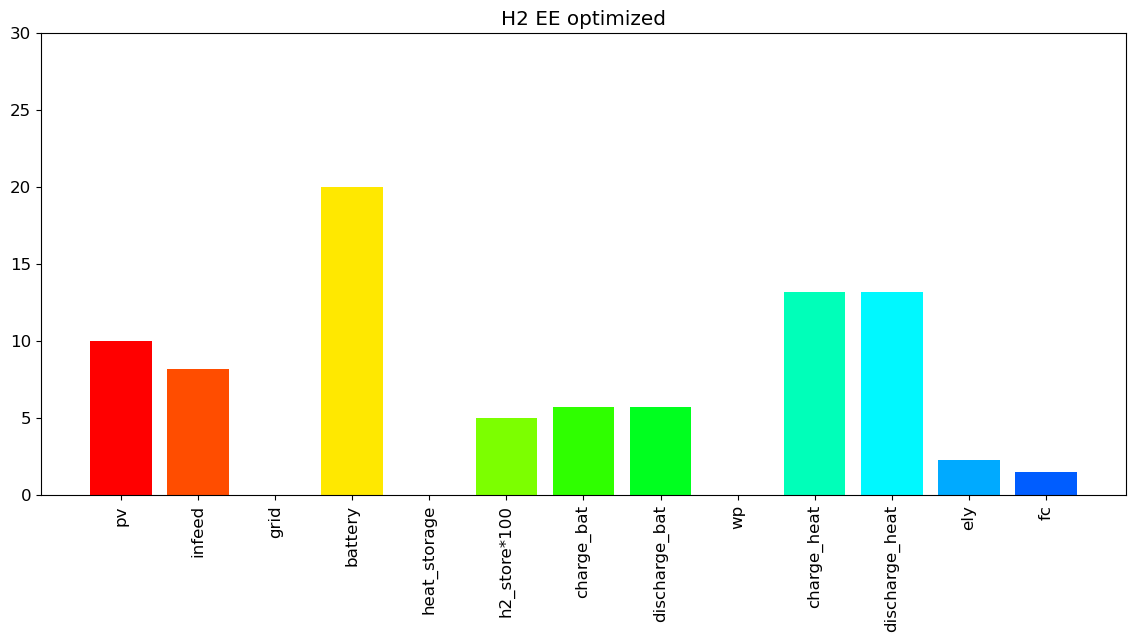

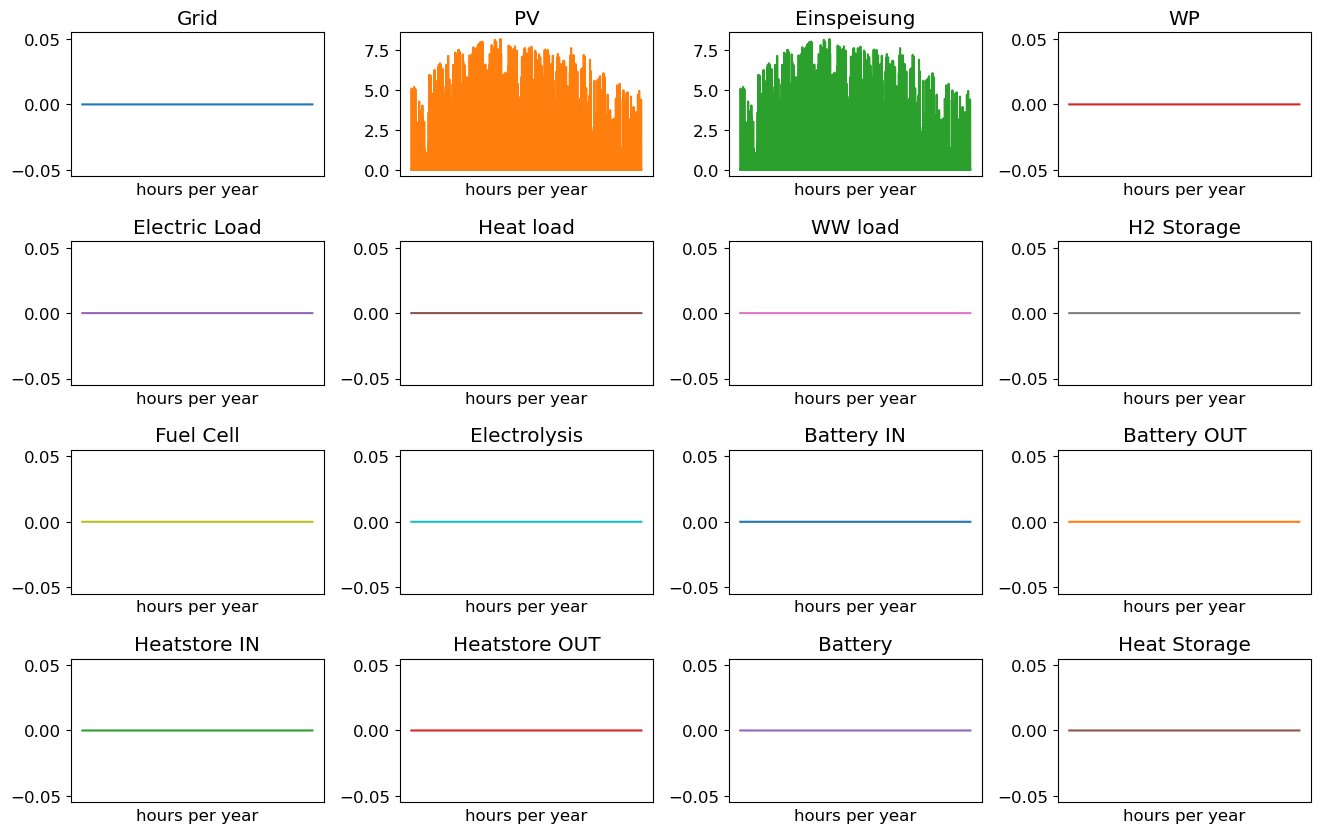

In [27]:
n_h2 = build_h2_network(electric_load=df_data['e_load_2p'], heat_load=df_data['h_load_2p'], ww_load=df_data['ww_load_2p'])

n_h2.optimize(solver_name='gurobi')

h2_results = analyse_single_network(n_h2, h2=True, plots=True)

# Simulationen

In [ ]:
# ABSOLUTES STANDARD Szenario mit allen 4 Netzwerken für 2P HH 
n_rg = build_ref_network_gas()
n_hg = build_h2_network_gas()
n_ree = build_ref_network()
n_hee = build_h2_network()

n_rg.optimize(solver_name='gurobi')
n_hg.optimize(solver_name='gurobi')
n_ree.optimize(solver_name='gurobi')
n_hee.optimize(solver_name='gurobi')


In [ ]:
# 2 people - result summary of STD Szenario without dependencies between networks
df_result_STD = calc_global_results(n_rg, n_hg, n_ree, n_hee, n_all=True)
print('2 People:')
df_result_STD

In [ ]:
# p_nom_opt and e_nom_opt summary
opt_values_STD = opt_value_summary(n_rg, n_hg, n_ree, n_hee, n_all=True)
#print(opt_values_STD)
#plot_opt_data(opt_values_STD)

In [ ]:
plot_series_data(opt_series_summary(n_rg, ref_gas=True))

In [ ]:
plot_series_data(opt_series_summary(n_hg, h2_gas=True))

In [ ]:
plot_series_data(opt_series_summary(n_ree, ref=True))

In [ ]:
plot_series_data(opt_series_summary(n_hee, h2=True))

In [ ]:
# Szenario 2-4-6 Personen Haushalt bei standardbedingungen ohne weitergabe von optimierten Werten
# 4 Personen
n_rg_4 = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])
n_hg_4 = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])
n_ree_4 = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])
n_hee_4 = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])

# 6 Personen
n_rg_6 = build_ref_network_gas(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])
n_hg_6 = build_h2_network_gas(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])
n_ree_6 = build_ref_network(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])
n_hee_6 = build_h2_network(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])

# optimize 4 Personen
n_rg_4.optimize(solver_name='gurobi')
n_hg_4.optimize(solver_name='gurobi')
n_ree_4.optimize(solver_name='gurobi')
n_hee_4.optimize(solver_name='gurobi')

# optimize 6 Personen
n_rg_6.optimize(solver_name='gurobi')
n_hg_6.optimize(solver_name='gurobi')
n_ree_6.optimize(solver_name='gurobi')
n_hee_6.optimize(solver_name='gurobi')

In [ ]:
# 4 people - result summary of STD Szenario without dependencies between networks
df_result_4p = calc_global_results(n_rg_4, n_hg_4, n_ree_4, n_hee_4, n_all=True)
print('4 People:')
df_result_4p

In [ ]:
# 6 people - result summary of STD Szenario without dependencies between networks
df_result_6p = calc_global_results(n_rg_6, n_hg_6, n_ree_6, n_hee_6, n_all=True)
print('6 People:')
df_result_6p

In [ ]:
plot_opt_data(opt_value_summary(n_rg_4, n_hg_4, n_ree_4, n_hee_4, n_all=True))

In [ ]:
plot_opt_data(opt_value_summary(n_rg_6, n_hg_6, n_ree_6, n_hee_6, n_all=True))

In [ ]:
plot_series_data(opt_series_summary(n_rg_4, ref_gas=True))

In [ ]:
plot_series_data(opt_series_summary(n_hg_4, h2_gas=True))

In [ ]:
plot_series_data(opt_series_summary(n_rg_6, ref_gas=True))

In [ ]:
plot_series_data(opt_series_summary(n_hg_6, h2_gas=True))

In [ ]:
# PV Threshhold runter setzen von 0.55 auf 0.4 - Vergleich von EE Netzwerken
pv_thresh = 0.4
df_season['ely_pv_threshhold'] = df_data['pv'].apply(lambda x: 1 if x >= pv_thresh else 0)

n_rg_4th = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_hg_4th = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_hg_4th.links_t.p_max_pu.ely = df_season['ely_pv_threshhold']
n_r_4th = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_h_4th = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_h_4th.links_t.p_max_pu.ely = df_season['ely_pv_threshhold']

n_rg_4th.optimize(solver_name='gurobi')
n_hg_4th.optimize(solver_name='gurobi')
n_r_4th.optimize(solver_name='gurobi')
n_h_4th.optimize(solver_name='gurobi')

df_thresh_test = pd.concat([calc_global_results(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True),
                           calc_global_results(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True)], axis=0)
print("Comparation changes from PV Threshhold: row1-4:0.55; row5-8: new Threshhold")
df_thresh_test

In [ ]:
plot_opt_data(opt_value_summary(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True))

In [ ]:
plot_opt_data(opt_value_summary(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True))

In [ ]:
plot_series_data(opt_series_summary(n_r_4th, ref=True))

In [ ]:
plot_series_data(opt_series_summary(n_h_4th, h2=True))

# Sensitivität

In [28]:
# CO2 Sensitivity 2,4 people households
# -> without dependencies like: optimized values from Reference Networks are transfered to H2 Networks 
all_res_2ee = {}
all_res_2g = {}
all_res_4ee = {}
all_res_4g = {}


# 2 Residents
# Ref Networks
ee2_ref = build_ref_network()
g2_ref = build_ref_network_gas()
ee2_ref.optimize(solver_name='gurobi')
g2_ref.optimize(solver_name='gurobi')

# get reference results
dfs_ee2_ref = analyse_single_network(ee2_ref, ref=True)
dfs_g2_ref = analyse_single_network(g2_ref, ref_gas=True)


# H2 Networks
ee2_h2 = build_h2_network()
g2_h2 = build_h2_network_gas()
ee2_h2.optimize(solver_name='gurobi')
g2_h2.optimize(solver_name='gurobi')

# get h2 initial results and calculate base co2
dfs_ee2_h2 = analyse_single_network(ee2_h2, h2=True)
dfs_g2_h2 = analyse_single_network(g2_h2, h2_gas=True)
base_co2_ee2 = dfs_ee2_h2[2].loc['CO2-Emission [kg/a]', 'analytic values']
base_co2_g2 = dfs_g2_h2[2].loc['CO2-Emission [kg/a]', 'analytic values']


# generate reference results for 2 Inhabitants:
results_2p_ee = analyse_single_network(ee2_ref, ref=True, sensitivity_variable='Reference')
results_2p_g = analyse_single_network(g2_ref, ref_gas=True, sensitivity_variable='Reference')

# reduce co2-Emissions step by step and add to results
for co2_lim in np.arange(1, 0.89, -0.1):
    print('Current CO2: {}%:'.format(co2_lim*100), "\nGas: ", co2_lim * base_co2_g2, '\nEE: ', co2_lim * base_co2_ee2)
    print('Inhabitants: -> 2')
    ee2_h2.global_constraints.loc['co2-limit', 'constant'] = co2_lim * base_co2_ee2
    g2_h2.global_constraints.loc['co2-limit', 'constant'] = co2_lim * base_co2_g2
    ee2_h2.optimize(solver_name='gurobi')
    g2_h2.optimize(solver_name='gurobi')
    
    results_2p_ee = results_2p_ee.append(analyse_single_network(ee2_h2, h2=True, sensitivity_variable=co2_lim))
    results_2p_g = results_2p_g.append(analyse_single_network(g2_h2, h2_gas=True, sensitivity_variable=co2_lim))
    all_res_2ee[co2_lim] = analyse_single_network(ee2_h2, h2=True)
    all_res_2g[co2_lim] = analyse_single_network(g2_h2, h2_gas=True)


# 4 Residents: 
# Ref Networks
ee4_ref = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
g4_ref = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
ee4_ref.optimize(solver_name='gurobi')
g4_ref.optimize(solver_name='gurobi')

# get reference results
dfs_ee4_ref = analyse_single_network(ee4_ref, ref=True)
dfs_g4_ref = analyse_single_network(g4_ref, ref_gas=True)


# H2 Networks
ee4_h2 = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
g4_h2 = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
ee4_h2.optimize(solver_name='gurobi')
g4_h2.optimize(solver_name='gurobi')

# calculate co2 base value
dfs_ee4_h2 = analyse_single_network(ee4_h2, h2=True)
dfs_g4_h2 = analyse_single_network(g4_h2, h2_gas=True)
base_co2_ee4 = dfs_ee4_h2[2].loc['CO2-Emission [kg/a]', 'analytic values']
base_co2_g4 = dfs_g4_h2[2].loc['CO2-Emission [kg/a]', 'analytic values']


# generate reference results for 4 Inhabitants:
results_4p_ee = analyse_single_network(ee4_ref, ref=True, sensitivity_variable='Reference')
results_4p_g = analyse_single_network(g4_ref, ref_gas=True, sensitivity_variable='Reference')

# reduce co2-Emissions step by step and add to results
for co2_lim4 in np.arange(1, 0.89, -0.05):
    print('Current CO2: {}%:'.format(co2_lim4*100), "\nGas: ", co2_lim4 * base_co2_g4, '\nEE: ', co2_lim4 * base_co2_ee4)
    print('Inhabitants: -> 4')
    ee4_h2.global_constraints.loc['co2-limit', 'constant'] = co2_lim4 * base_co2_ee4
    g4_h2.global_constraints.loc['co2-limit', 'constant'] = co2_lim4 * base_co2_g4
    ee4_h2.optimize(solver_name='gurobi')
    g4_h2.optimize(solver_name='gurobi')
    
    results_4p_ee = results_4p_ee.append(analyse_single_network(ee4_h2, h2=True, sensitivity_variable=co2_lim4))
    results_4p_g = results_4p_g.append(analyse_single_network(g4_h2, h2_gas=True, sensitivity_variable=co2_lim4))
    all_res_4ee[co2_lim4] = analyse_single_network(ee4_h2, h2=True)
    all_res_4g[co2_lim4] = analyse_single_network(g4_h2, h2_gas=True)
    
result_lst = [results_2p_ee, results_2p_g, results_4p_ee, results_4p_g]

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759],
           dtype='int64', name='snapshot', length=8760)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759],
           dtype='int64', name='snapshot', length=8760)
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.93it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-5pzsahpg.lp
Reading time = 0.34 seconds
obj: 227767 rows, 105125 columns, 402966 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227767 rows, 105125 columns and 402966 nonzeros
Model fingerprint: 0x4377d0fc
Coefficient statistics:
  Matrix range     [4e-01, 1e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 192101 rows and 51937 columns
Presolve time: 0.14s
Presolved: 35666 rows, 53188 columns, 164544 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6300000e+03   0.000000e+00   0.000000e+

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105125 primals, 227767 duals
Objective: 2.63e+03
Solver model: available
Solver message: 2

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759],
           dtype='int64', name='snapshot', length=8760)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759],
           dtype='int64', name='snapshot', length=8760)
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 25.72it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-4wcdvutb.lp
Reading time = 0.48 seconds
obj: 271573 rows, 122649 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271573 rows, 122649 columns and 516852 nonzeros
Model fingerprint: 0x73eb4de2
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201493 rows and 35045 columns
Presolve time: 0.19s
Presolved: 70080 rows, 87604 columns, 219000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122649 primals, 271573 duals
Objective: 0.00e+00
Solver model: available
Solver message: 2



AttributeError: 'DataFrame' object has no attribute 'h2_storage'

In [ ]:
# H2 Storage Capacity influence (Scenario 2,4,6pers, EE_reference)
# build networks
sens_data_sc_ee = {}
all_res_sc_ee = {}

# loop person quantity
for pers in ['2p', '4p', '6p']:
    # setup reference network
    sc_ref = build_ref_network(electric_load=df_data['e_load_'+pers],
                               heat_load=df_data['h_load_'+pers],
                               ww_load=df_data['ww_load_'+pers])
    
    # optimize and get the reference result
    sc_ref.optimize(solver_name='gurobi')
    sens_result_sc = analyse_single_network(sc_ref, ref=True, sensitivity_variable='reference')


    # initialize h2 network
    sc_h2 = build_h2_network(electric_load=df_data['e_load_'+pers],
                             heat_load=df_data['h_load_'+pers],
                             ww_load=df_data['ww_load_'+pers])
    # set h2_storage non extendable to force dimension
    sc_h2.stores.e_nom_extendable.h2_storage = False
    
    # sensitivity analysis by looping over h2_storage capacity
    for capacity in np.arange(h2_storage_params['e_nom_min'], h2_storage_params['e_nom_max']+501, 500):
        print('Current Capacity: ', capacity,'\nCurrent Loadsize: ', pers)
        sc_h2.stores.e_nom.h2_storage = capacity
        sc_h2.optimize(solver_name='gurobi')
        sens_result_sc = sens_result_sc.append(analyse_single_network(sc_h2, h2=True, sensitivity_variable=capacity))
        all_res_sc_ee[pers + "_" + str(capacity)] = analyse_single_network(sc_h2, h2=True, plots=True)
        
        
    # copy results according to scenario, deepcopy and delete the initial dataset
    if pers == '2p':
        sc_res_2p = sens_result_sc.copy(deep=True)
        sens_data_sc_ee[pers] = sc_res_2p
        del sens_result_sc
    if pers == '4p':
        sc_res_4p = sens_result_sc.copy(deep=True)
        sens_data_sc_ee[pers] = sc_res_4p
        del sens_result_sc
    if pers == '6p':
        sc_res_6p = sens_result_sc.copy(deep=True)
        sens_data_sc_ee[pers] = sc_res_6p
        del sens_result_sc

In [ ]:
# H2 Storage Capacity influence (Scenario 2,4,6pers, Gas_reference)
# build networks
sens_data_sc_gas = {}
all_res_sc_gas = {}

# loop person quantity
for pers in ['2p', '4p', '6p']:
    # setup reference network
    sc_ref = build_ref_network_gas(electric_load=df_data['e_load_'+pers],
                                   heat_load=df_data['h_load_'+pers],
                                   ww_load=df_data['ww_load_'+pers])
    
    # optimize and get the reference result
    sc_ref.optimize(solver_name='gurobi')
    sens_result_sc = analyse_single_network(sc_ref, ref_gas=True, sensitivity_variable='reference')


    # initialize h2 network
    sc_h2 = build_h2_network_gas(electric_load=df_data['e_load_'+pers],
                                 heat_load=df_data['h_load_'+pers],
                                 ww_load=df_data['ww_load_'+pers])
    # set h2_storage non extendable to force dimension
    sc_h2.stores.e_nom_extendable.h2_storage = False
    
    # sensitivity analysis by looping over h2_storage capacity
    for capacity in np.arange(h2_storage_params['e_nom_min'], h2_storage_params['e_nom_max']+501, 500):
        print('Current Capacity: ', capacity,'\nCurrent Loadsize: ', pers)
        sc_h2.stores.e_nom.h2_storage = capacity
        sc_h2.optimize(solver_name='gurobi')
        sens_result_sc = sens_result_sc.append(analyse_single_network(sc_h2, h2_gas=True, sensitivity_variable=capacity))
        all_res_sc_gas[pers + "_" + str(capacity)] = analyse_single_network(sc_h2, h2_gas=True, plots=True)
        
        
    # copy results according to scenario, deepcopy and delete the initial dataset
    if pers == '2p':
        sc_res_2p = sens_result_sc.copy(deep=True)
        sens_data_sc_gas[pers] = sc_res_2p
        del sens_result_sc
    if pers == '4p':
        sc_res_4p = sens_result_sc.copy(deep=True)
        sens_data_sc_gas[pers] = sc_res_4p
        del sens_result_sc
    if pers == '6p':
        sc_res_6p = sens_result_sc.copy(deep=True)
        sens_data_sc_gas[pers] = sc_res_6p
        del sens_result_sc
    

In [ ]:
# Cost Reduction Test - from when does the Hydrogen System become economical attractive 
# (Comparation between Hydrogen Networks) - (Scenario: 4p Household, cost reduction influence)
# Giving an Overview on 3 Scenarios (min, std, max)-Cost. Therefore 3-5 years in order to see effects from cost reduction
# When does hydrogen get the economic legitimation 

df_cost = cost_reduction_calculation(initial_cost=ely_params['capital_cost']*2.3)
scenario = df_cost[0:31:7]

res_reports_ee = []
res_reports_gas = []

# Network Setup
hy_gas = build_h2_network_gas()
hy_ee = build_h2_network()
nets = [hy_gas, hy_ee]
hy_gas.links.p_nom_max.heating_rod = wp_params['p_nom']


for col in ['min', 'std', 'max']:
    for i, val in enumerate(scenario[col]):
        # setup capital_cost and optimize network
        for n in nets:
            print(col, i, val)
            n.links.capital_cost.ely = val/ely_params['p_nom']
            n.links.capital_cost.fc = val/fc_params['p_nom']
            n.stores.capital_cost.h2_storage = val/h2_storage_params['e_nom_min']
            n.stores.capital_cost.battery = val/battery_picea_params['e_nom']
            
            n.optimize(solver_name='gurobi')
            
        res_reports_gas.append(analyse_single_network(hy_gas, h2_gas=True, plots=True))
        res_reports_ee.append(analyse_single_network(hy_ee, h2=True, plots=True))

        
summary = {}



        



In [ ]:
summary = {}

for col in ['min', 'std', 'max']:
    for i, elem in enumerate(scenario[col]):
        summary[col] = [[res_reports_gas[i][2].loc['Self Sufficiency [%]', 'analytic values'],
                         res_reports_gas[i][2].loc['Payback Period [a]', 'analytic values'],
                         res_reports_gas[i][2].loc['CAPEX [€]', 'analytic values'],
                         res_reports_gas[i][2].loc['CO2-Emission [kg/a]', 'analytic values'],
                         res_reports_gas[i][1].loc['h2_storage', 'H2 EE optimized']],
                        [res_reports_ee[i][2].loc['Self Sufficiency [%]', 'analytic values'],
                         res_reports_ee[i][2].loc['Payback Period [a]', 'analytic values'],
                         res_reports_ee[i][2].loc['CAPEX [€]', 'analytic values'],
                         res_reports_ee[i][2].loc['CO2-Emission [kg/a]', 'analytic values'],
                         res_reports_ee[i][1].loc['h2_storage', 'H2 EE optimized']]]
        
        



In [ ]:
summary_ee = {}
summary_gas = {}
for i in range(len(res_reports_ee)):
    summary_ee['Self Sufficiency [%]'] = [].append(res_reports_ee[i][2].loc['Self Sufficiency [%]', 'analytic values'])
    summary_ee['Payback Period [a]'] = [].append(res_reports_ee[i][2].loc['Payback Period [a]', 'analytic values'])
    summary_ee['CAPEX [€]'] = [].append(res_reports_ee[i][2].loc['CAPEX [€]', 'analytic values'])
    summary_ee['CO2-Emission [kg/a]'] = [].append(res_reports_ee[i][2].loc['Self Sufficiency [%]', 'analytic values'])
    summary_ee['h2_storage'] = [].append(res_reports_ee[i][2].loc['h2_storage', 'H2 EE optimized'])

    
summary_ee

In [ ]:
#ALT co2 SENSITIVITÄTSTEST
'''
#n_ref = build_ref_network()

n_ref.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen
n_ref.optimize(solver_name='gurobi')

#n_h2 = build_h2_network()
#n_ref.optimize(solver_name='gurobi')

results_ref = auswertungsfunktion(n_ref,100,0)
basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


#results_ref = pd.DataFrame(auswertungsfunktion(n_ref,100,0))
#basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen

for co2_limit in np.flip(np.arange(0.7, 1, 0.10)):
    print(co2_limit* basis_co2_emissions)
    n_ref.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_ref.optimize(solver_name='gurobi')
    results_ref = results_ref.append(auswertungsfunktion(n_ref, co2_limit * 100))
    '''

In [ ]:
res_reports_ee

In [ ]:
#ALT co2 SENSITIVITÄTSTEST

'''
n_h2.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen

#Iterationen
#n_ref = build_ref_network()
#n_h2 = build_h2_network()
n_h2.optimize(solver_name='gurobi')
#results_ref = pd.DataFrame()
#results_h2 = pd.DataFrame()
results_h2 = pd.DataFrame(auswertungsfunktion(n_h2,100,0))
basis_co2_emissions = results_h2['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


for co2_limit in np.flip(np.arange(0.5, 1, 0.2)):
    print(co2_limit* basis_co2_emissions)
    n_h2.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_h2.optimize(solver_name='gurobi')
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, co2_limit * 100))
  

for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): 
    print(strompreis_bezug)
    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_h2.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_ref.optimize(solver_name = 'gurobi')
    n_h2.optimize(solver_name='gurobi')
    n_h2.stores.loc['battery', 'e_nom'] = n_ref.stores.e_nom_opt.battery
    n_h2.stores.loc['heat_storage', 'e_nom'] = n_ref.stores.e_nom_opt.heat_storage
    
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, strompreis_bezug))
    results_ref = results_ref.append(auswertungsfunktion(n_ref, strompreis_bezug))
'''


In [ ]:
#ALT!!! - Test mit statischem Preis (1) und Preisprofil (2)
'''
# setup reference networks
n_ref1 = build_ref_network()

n_ref2 = build_ref_network()
n_ref2.generators_t.marginal_cost.grid = df_price_data["2021"]
# optimize
n_ref1.optimize(solver_name='gurobi')
n_ref2.optimize(solver_name='gurobi')

# setup h2 networks
n_hy1 = build_h2_network()
#n_hy1.stores.e_nom.battery = n_ref1.stores.e_nom_opt.battery
n_hy1.stores.e_nom.heat_storage = n_ref1.stores.e_nom_opt.heat_storage
n_hy1.links.p_nom.wp = n_ref1.links.p_nom_opt.wp
#n_hy1.links_t.p_max_pu.ely = df_season["ely"]
#n_hy1.links_t.p_max_pu.fc = df_season["fc"]

n_hy2 = build_h2_network()
#n_hy2.stores.e_nom.battery = n_ref2.stores.e_nom_opt.battery
n_hy2.stores.e_nom.heat_storage = n_ref2.stores.e_nom_opt.heat_storage
n_hy2.links.p_nom.wp = n_ref2.links.p_nom_opt.wp
n_hy2.links.p_nom_max.charge_heat = n_ref2.links.p_nom_opt.wp
n_hy2.links.p_nom_max.discharge_heat = n_ref2.links.p_nom_opt.wp
n_hy2.generators_t.marginal_cost.grid = df_price_data["2021"]
#n_hy2.links_t.p_max_pu.ely = df_season["ely"]
#n_hy2.links_t.p_max_pu.fc = df_season["fc"]

# optimize networks
n_hy1.optimize(solver_name='gurobi')
n_hy2.optimize(solver_name='gurobi')

ref1_data = opt_series_summary(n_ref1, ref=True)
ref2_data = opt_series_summary(n_ref2, ref=True)
hy1_data = opt_series_summary(n_hy1, h2=True)
hy2_data = opt_series_summary(n_hy2, h2=True)
'''

In [ ]:
#ALT!!! - Test mit statischem Preis (1) und Preisprofil (2)
'''
# setup reference networks
n_gas1 = build_ref_network_gas()

n_gas2 = build_ref_network_gas()
n_gas2.generators_t.marginal_cost.grid = df_price_data["2022"]
# optimize
n_gas1.optimize(solver_name='gurobi')
n_gas2.optimize(solver_name='gurobi')

# setup h2 networks
n_hy3 = build_h2_network()
#n_hy3.stores.e_nom.battery = n_gas1.stores.e_nom_opt.battery
n_hy3.stores.e_nom.heat_storage = n_gas1.stores.e_nom_opt.heat_storage

n_hy4 = build_h2_network()
#n_hy4.stores.e_nom.battery = n_gas2.stores.e_nom_opt.battery
n_hy4.stores.e_nom.heat_storage = n_gas2.stores.e_nom_opt.heat_storage
n_hy4.links.p_nom_max.charge_heat = n_gas2.links.p_nom_opt.gas_boiler
n_hy4.links.p_nom_max.discharge_heat = n_gas2.links.p_nom_opt.gas_boiler
n_hy4.generators_t.marginal_cost.grid = df_price_data["2022"]
#n_hy4.links_t.p_max_pu.ely = df_season["ely"]
#n_hy4.links_t.p_max_pu.fc = df_season["fc"]

# optimize networks
n_hy3.optimize(solver_name='gurobi')
n_hy4.optimize(solver_name='gurobi')

gas1_data = opt_series_summary(n_gas1, ref_gas=True)
gas2_data = opt_series_summary(n_gas2, ref_gas=True)
hy3_data = opt_series_summary(n_hy3, h2=True)
hy4_data = opt_series_summary(n_hy4, h2=True)
'''